# Setup
讀取環境變數、初始化語言模型（LLM）與初始化Aralia工具

In [1]:
! pip install git+https://github.com/BigObjectGraceChen/OpenRAG.git


  Cloning https://github.com/BigObjectGraceChen/OpenRAG.git to /private/var/folders/l3/l158zncd2b5508v6161klssw0000gn/T/pip-req-build-fl7nex2j
  Running command git clone --filter=blob:none --quiet https://github.com/BigObjectGraceChen/OpenRAG.git /private/var/folders/l3/l158zncd2b5508v6161klssw0000gn/T/pip-req-build-fl7nex2j
  Resolved https://github.com/BigObjectGraceChen/OpenRAG.git to commit 03bed44e1798481cd51c10af6f16d9052f872bc5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for aralia_openrag: filename=aralia_openrag-0.1.0-py3-none-any.whl size=6341 sha256=4857b569061d402cd9e8aaca29731de3cc11ffb02d7d85d4fcfd2851f2d3cf27
  Stored in directory: /private/var/folders/l3/l158zncd2b5508v6161klssw0000gn/T/pip-ephem-wheel-cache-dq8zgkiu/wheels/2e/b4/94/f0b1cad396820c7bb4f43455a2793829aa665808d38d965a50
Successfully built aralia_openrag


In [ ]:
! pip install langgraph dotenv gradio

  Using cached langchain_openai-0.3.11-py3-none-any.whl.metadata (2.3 kB)
  Using cached langgraph-0.3.21-py3-none-any.whl.metadata (7.7 kB)
  Using cached dotenv-0.9.9-py2.py3-none-any.whl.metadata (279 bytes)
  Using cached gradio-5.23.1-py3-none-any.whl.metadata (16 kB)
  Using cached langchain_core-0.3.49-py3-none-any.whl.metadata (5.9 kB)
  Using cached openai-1.69.0-py3-none-any.whl.metadata (25 kB)
  Using cached tiktoken-0.9.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.7 kB)
  Using cached langgraph_checkpoint-2.0.23-py3-none-any.whl.metadata (4.6 kB)
  Using cached langgraph_prebuilt-0.1.7-py3-none-any.whl.metadata (5.0 kB)
  Using cached langgraph_sdk-0.1.60-py3-none-any.whl.metadata (1.8 kB)
  Using cached xxhash-3.5.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached python_dotenv-1.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached anyio-4.9.0-py3-none-any.whl.metadata (4.7 kB)
  Using c

In [ ]:
from langchain_core.prompts import PromptTemplate
from langgraph.graph import START, END, StateGraph
from dotenv import load_dotenv
from typing_extensions import TypedDict
import gradio as gr
from aralia_openrag import schema, tools
from pydantic import BaseModel, Field

/Users/gracechen/Documents/BigObject/Consultant/github/OpenRAG/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os

if "COLAB_GPU" in os.environ:
    from google.colab import userdata
    from google.colab.userdata import SecretNotFoundError

    def get_secret(key, default=''):
        try:
            return userdata.get(key)
        except SecretNotFoundError:  # 捕獲密鑰不存在的錯誤
            return default

    os.environ["OPENAI_API_KEY"] = get_secret('OPENAI_API_KEY', '')
    os.environ["GOOGLE_API_KEY"] = get_secret('GOOGLE_API_KEY', '')
    os.environ["ANTHROPIC_API_KEY"] = get_secret('ANTHROPIC_API_KEY', '')
    os.environ["ARALIA_ENDPOINT"] = get_secret('ARALIA_ENDPOINT', '')
    os.environ["ARALIA_TOKEN"] = get_secret('ARALIA_TOKEN', '')
else:
    from dotenv import load_dotenv
    load_dotenv()


True

In [ ]:
! pip install langchain_openai

In [5]:
#Initializing the language model with the OpenAI model
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
! pip install langchain_google_genai

In [4]:
#Initializing the language model with the Gemini model
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [6]:
! pip install langchain_anthropic

  Using cached anthropic-0.49.0-py3-none-any.whl.metadata (24 kB)
Using cached anthropic-0.49.0-py3-none-any.whl (243 kB)


In [7]:
#Initializing the language model with the Claude model
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model='claude-3-opus-20240229')

In [8]:
# Initializing the Aralia tools
aralia = tools.Aralia()

# State Definition
定義一組資料結構，作為資料在節點（Nodes）中流轉與交換，並規範狀態的結構化處理

In [9]:
class State(TypedDict):
    question: str                          # The question asked by the user
    keywords: list[str]                    # The keywords used to search for the datasets
    datasets: list[schema.Dataset]         # The datasets found(metadata only)
    query: list[schema.Query]              # The api query to be executed
    results: list[schema.QueryResult]      # The results of the query
    answer: str                            # The answer to the user's question
    error : str                            # The error message if any

# Node Definition
具體定義各種節點（Node）的行為與功能，這些節點作為流程中的核心運算單元。

## Keyword Extractor
根據使用者的問題，篩選出關鍵字

In [10]:
keyword_extract_template = PromptTemplate.from_template('''
請擔任專業資訊檢索專家
依此流程處理查詢：
1. 識別問題中的核心主語
2. 提取所有並列查詢點（透過連接詞/頓號辨識）
3. 若查詢點之間是相對獨立的，則保持原樣，若查詢點與核心主語存在修飾關係，則將其組合

測試案例：
- **輸入**：「電動車電池技術發展和安全性問題」
- **輸出**：`["電動車電池技術發展", "電動車安全性問題"]`

- **輸入**：「空氣污染與健康問題」
- **輸出**：`["空氣污染", "健康問題"]

- 請根據用戶問題的語言來決定輸出語言，不要擅自翻譯
用戶的問題：{question}
''')

In [11]:
def keyword_extractor(state: State):
    prompt = keyword_extract_template.invoke(
        {
            "question": state["question"],
        }
    )

    class keyword_extract_output(BaseModel):
        keywords: list[str] = Field(description="keywords extracted from the question")
    
    try:
        structured_llm = llm.with_structured_output(keyword_extract_output)
        result = structured_llm.invoke(prompt)
    except Exception as e:
        return {"error": f"Keyword Extractor failed: {e}"}
    return {"keywords": result.keywords}
    

In [12]:
# Test the keyword_extractor node
keyword_extractor({"question":"電影票房與空氣品質的關係"})

{'keywords': ['電影票房', '空氣品質的關係']}

## Dataset Searcher
用關鍵字搜尋Aralia星球中可能的資料集

In [13]:
dataset_search_template = PromptTemplate.from_template('''
您是世界頂尖的數據分析師，擅長從海量資料集中精準過濾高價值內容
**已有資訊**:
1.問題: {question}
2.搜尋得來的可能資料集: {datasets}

**篩選流程**：
1. 【需求解析層】
    - 解析原始問題的雙重維度：
        * 顯性需求：用戶直接表述的關鍵詞（例：發售時間）
        * 隱性需求：領域知識推導的必要條件（例：需包含跨平台數據）

2. 【質量評估層】→ 依序執行：
    - 相關性評分（0-10分）：
        • 匹配度（主標籤吻合度）
        • 覆蓋度（時間範圍/地域範圍/平台類型）
        • 顆粒度（數據詳盡程度）
    - 可信度驗證：
        • 數據來源權重（學術機構>政府報告>企業白皮書）
        • 更新頻率（近3年權重+20%）
        • 取樣方法說明完整性

3. 【動態調整機制】：
    - 當用戶補充說明後，自動更新篩選權重參數
    - 建立排除關鍵詞黑名單（例：刪除含「預測模型」的理論研究類數據）
''')

In [14]:
def dataset_searcher(state: State):
    # Search datasets based on the keywords
    datasets = []
    for keyword in state["keywords"]:
        try:
            response = aralia.SearchDatasets(keyword) 
        except Exception as e:
            return {"error": f"Dataset Searcher failed: {e}"}
        datasets.extend(response)
    if datasets == []:
        return {"datasets": []}
    # Filter the datasets based on the question
    prompt = dataset_search_template.invoke(
        {
            "question": state["question"],
            "datasets": datasets,
        }
    )

    class dataset_search_output(BaseModel):
        datasets: list[schema.Dataset] = Field(description="datasets found based on the question")
    
    try:
        structured_llm = llm.with_structured_output(dataset_search_output)
        result = structured_llm.invoke(prompt)
    except Exception as e:
        return {"error": f"Dataset Searcher failed: {e}"}
    
    datasets = result.datasets
    if datasets == []:
        return {"datasets": []}

    # get columns information
    for i, dataset in enumerate(datasets):
        try:
            columns = aralia.GetColumnInfo(dataset)
            datasets[i]['columns'] = columns
        except Exception as e:
            return {"error": f"Dataset Searcher failed: {e}"}
    return {"datasets": datasets}

In [16]:
# Test the dataset_searcher node
dataset_searcher({"question":"電影票房與空氣品質的關係","keywords":['電影票房', '空氣品質的關係']})

{'error': "Dataset Searcher failed: 2 validation errors for dataset_search_output\ndatasets.0.columns\n  Field required [type=missing, input_value={'id': 'dnT3tXLZuxggmFdXG...-air.araliadata.io/api'}, input_type=dict]\n    For further information visit https://errors.pydantic.dev/2.11/v/missing\ndatasets.1.columns\n  Field required [type=missing, input_value={'id': '6h7D2wyfsxx6BUadP...ment.araliadata.io/api'}, input_type=dict]\n    For further information visit https://errors.pydantic.dev/2.11/v/missing"}

## Query Generator
根據使用者的問題和相關的資料集生成查詢語法


In [14]:
query_generate_template = PromptTemplate.from_template('''
你是一位資深數據分析師，專精於統計數據的分析。你擅長從數據中挖掘洞見，並識別不同數據集之間的關聯性。

我需要你根據用戶的問題 {question}，並基於以下資料表，生成條形圖的配置建議。每個建議都應該是一個有效的查詢 (query)，並遵守以下規則：

每個查詢必須基於單一資料集 (dataset)。
查詢必須包含以下內容：
X 軸：資料集中對應的類別欄位。
Y 軸：數值欄位及其對應的聚合函數。
每個資料集最多產生一個查詢。
X 軸與 Y 軸的欄位必須來自同一個資料集，並且其元數據（id, name, type）需與資料集定義一致。
資料表
{datasets}

操作說明
請依以下步驟執行：

意圖解讀：分析用戶的問題，推測其可能的分析需求。
欄位選擇：從每個資料集中挑選出 X 軸和 Y 軸的欄位組合。
圖表建議：為每個資料集生成最多一個條形圖的配置。
                                                       
關鍵要求
X 軸限制：欄位類型必須為類別型（例如，nominal、ordinal 或 spatial），其格式需與資料集元數據一致。
Y 軸限制：欄位類型必須為數值型（例如，integer、float），並且聚合函數應符合欄位類型（例如，數值型欄位可用 sum、avg）。
一致性：確保 columnID、column_name 和 type 與資料集元數據一致。
單一資料集限制：每個查詢不可跨資料集選取欄位。
''')

In [15]:
def query_generator(state: State):
    prompt_base = query_generate_template.invoke(
        {
            "question": state["question"],
            "datasets": state["datasets"],
        }
    )

    class query_generate_output(BaseModel):
        query: list[schema.Query] = Field(description="queries generated based on the question and datasets")

    retry_limit = 5  # 最大重試次數
    retries = 0      # 當前重試次數
    last_result = None  # 保存上一次的生成結果

    while retries < retry_limit:
        # 每次生成新 prompt
        if last_result:
            prompt = (
                f"{prompt_base}\n\n"
                f"上次生成的查詢結果如下：\n"
                f"{last_result}\n"
                f"!!ERROR!!: 上述結果存在以下問題：{validation_result['message']}。"
                f"請基於該結果進行修正，生成符合要求的查詢。"
            )
        else:
            prompt = prompt_base

        try:
            structured_llm = llm.with_structured_output(query_generate_output)
            result = structured_llm.invoke(prompt)
        except Exception as e:
            return {"error": f"Query Generator failed: {e}"}

        # 驗證每個 query
        all_valid = True
        for query in result.query:
            validation_result = aralia.QueryValidation(query, state["datasets"])
            if validation_result["status"] == "fail":
                print(validation_result)
                all_valid = False
                last_result = result.query  # 保存本次結果作為上下文
                break  # 如果有失敗，直接退出檢查

        if all_valid:
            return {"query": result.query}
        
        retries += 1  # 增加重試次數

    # 超過重試次數仍然失敗，返回錯誤
    return {"error": "Query Generator failed after 5 retries due to validation issues."}


In [15]:
datasets = [{'id': '6h7D2wyfsxx6BUadPAyxHp',
   'name': '電影票房資料',
   'description': '此數據集記錄自2020年5月30日起台灣戲院每日上映電影的票房資訊，內容包括電影資訊、當日票房及上映影廳數等。\n更新頻率: 每周(周五)',
   'sourceType': 'x_planet',
   'siteName': '影視娛樂星球',
   'sourceURL': 'https://tw-entertainment.araliadata.io/api',
   'columns': [{'id': '4dPMMB7EdpRRd4iUqqFev9',
     'name': 'col_1',
     'type': 'nominal',
     'datasetID': '6h7D2wyfsxx6BUadPAyxHp',
     'description': '電影製作國家或地區',
     'displayName': '製作國家',
     'ordinalPosition': 1,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'ThhAzxVETmijdJvJQWKfYb',
     'name': 'col_2',
     'type': 'nominal',
     'datasetID': '6h7D2wyfsxx6BUadPAyxHp',
     'description': '',
     'displayName': '中文片名',
     'ordinalPosition': 2,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'W5VfaTHpyLkZFrLPJ6E3PU',
     'name': 'col_3',
     'type': 'date',
     'datasetID': '6h7D2wyfsxx6BUadPAyxHp',
     'description': '',
     'displayName': '上映日期',
     'ordinalPosition': 3,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'WuJtbcpU6GTUzKZpeWMXNy',
     'name': 'col_4',
     'type': 'nominal',
     'datasetID': '6h7D2wyfsxx6BUadPAyxHp',
     'description': '申請上映之法人',
     'displayName': '申請人',
     'ordinalPosition': 4,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'BrfyAoYW7obmc7ZjsHdx3V',
     'name': 'col_5',
     'type': 'text',
     'datasetID': '6h7D2wyfsxx6BUadPAyxHp',
     'description': '',
     'displayName': '出品',
     'ordinalPosition': 5,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'MUtT9HwipEVxTBRHjmgq2d',
     'name': 'col_6',
     'type': 'integer',
     'datasetID': '6h7D2wyfsxx6BUadPAyxHp',
     'description': '',
     'displayName': '上映院數',
     'ordinalPosition': 6,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'ABBVb9AjQBabr7xhUb6qWL',
     'name': 'col_7',
     'type': 'integer',
     'datasetID': '6h7D2wyfsxx6BUadPAyxHp',
     'description': '',
     'displayName': '銷售票數',
     'ordinalPosition': 7,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'VaEPQP2ed8mWb6bqD52Y5j',
     'name': 'col_8',
     'type': 'float',
     'datasetID': '6h7D2wyfsxx6BUadPAyxHp',
     'description': '銷售票數與前日比較變動比例',
     'displayName': '銷售票數變動率',
     'ordinalPosition': 8,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'dToiKESLfXpqJTmqS5AjwE',
     'name': 'col_9',
     'type': 'float',
     'datasetID': '6h7D2wyfsxx6BUadPAyxHp',
     'description': '',
     'displayName': '銷售金額',
     'ordinalPosition': 9,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'TVVneBryJB6asJRF7qnDF5',
     'name': 'col_10',
     'type': 'date',
     'datasetID': '6h7D2wyfsxx6BUadPAyxHp',
     'description': '',
     'displayName': '資料日期',
     'ordinalPosition': 10,
     'sortingSettingID': '',
     'visible': True}]},
  {'id': 'dnT3tXLZuxggmFdXGFLpHt',
   'name': '每小時空氣品質監測',
   'description': '此數據集記錄自2023年10月起全台各測站每小時空氣數據，涵蓋多項空氣品質指標與基本氣象參數。',
   'sourceType': 'x_planet',
   'siteName': '生活空氣指南星球',
   'sourceURL': 'https://tw-air.araliadata.io/api',
   'columns': [{'id': 'XkcvRnEaRjrQDjjT5jKDKQ',
     'name': 'col_1',
     'type': 'nominal',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '',
     'displayName': '測站名稱',
     'ordinalPosition': 1,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'M9LZpw5KfyQpZCQRaGyueU',
     'name': 'col_2',
     'type': 'nominal',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '',
     'displayName': '測站所在縣市',
     'ordinalPosition': 2,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'fMLMcaSo7wCBcrByZRCeiK',
     'name': 'col_3',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '',
     'displayName': '空氣品質指標(AQI)',
     'ordinalPosition': 3,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'cRmDV4dk8vRVRHJdib8FNy',
     'name': 'col_4',
     'type': 'nominal',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '',
     'displayName': '汙染物質',
     'ordinalPosition': 4,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'HqFrh9PLJ9D8izzdFXUTNd',
     'name': 'col_5',
     'type': 'ordinal',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '',
     'displayName': '空氣品質狀態',
     'ordinalPosition': 5,
     'sortingSettingID': 'vXq6jzVgiN4aQbGLiYuCYF',
     'visible': True},
    {'id': '2uZxcbJ4MKzhVP3D97y7Qw',
     'name': 'col_6',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：ppb',
     'displayName': '二氧化硫 SO₂',
     'ordinalPosition': 6,
     'sortingSettingID': '',
     'visible': True},
    {'id': '6QjdjrEfMBWobmB4946srD',
     'name': 'col_7',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：ppb',
     'displayName': '一氧化硫 SO',
     'ordinalPosition': 7,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'jda9smsWp7g8cwwk8e8xdX',
     'name': 'col_8',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：ppb',
     'displayName': '臭氧 O₃',
     'ordinalPosition': 8,
     'sortingSettingID': '',
     'visible': True},
    {'id': '2dLjWaA858sizzvB2kTQix',
     'name': 'col_9',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：ppb。取最近連續 8 小時移動平均值',
     'displayName': '臭氧8小時移動平均',
     'ordinalPosition': 9,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'GvaPyqzoT6yhJigthxwZdH',
     'name': 'col_10',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': 'PM10，單位：μg/m^3',
     'displayName': '懸浮微粒',
     'ordinalPosition': 10,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'J35x8cqe8HuFxpatsiUwkr',
     'name': 'col_11',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': 'PM2.5，單位：μg/m^3',
     'displayName': '細懸浮微粒',
     'ordinalPosition': 11,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'W9WkaP4Ju3z84jPP3t2gk9',
     'name': 'col_12',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：ppb',
     'displayName': '二氧化氮 NO₂',
     'ordinalPosition': 12,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'cdTyTfHFNxw37gphdG6SGB',
     'name': 'col_13',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：ppb',
     'displayName': '氮氧化物 NOx',
     'ordinalPosition': 13,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'GfhTsg7WBHSZGua3QuVqgg',
     'name': 'col_14',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：ppb',
     'displayName': '一氧化氮 NO',
     'ordinalPosition': 14,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'kCnYdaCXFEaivqcPewgVtj',
     'name': 'col_15',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：公尺/秒 (m/s)',
     'displayName': '風速',
     'ordinalPosition': 15,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'DhxNqjaBUpMSPtTKmfcHYz',
     'name': 'col_16',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：度。\n正北0或360；正東90；正南180；正西270',
     'displayName': '風向',
     'ordinalPosition': 16,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'nPVLrd3yM4q53dFztihAEQ',
     'name': 'col_17',
     'type': 'datetime',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '格式:\nyyyy-MMddTHH:mm:ss+08:00',
     'displayName': '發佈時間',
     'ordinalPosition': 17,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'XrCqgJ7Xio6z8VkYxwZ7dP',
     'name': 'col_18',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：ppm。取最近連續 8 小時移動平均值',
     'displayName': '一氧化碳8小時移動平均',
     'ordinalPosition': 18,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'NfNRFZB3wN4m4n5DqBm9EC',
     'name': 'col_19',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': 'pm2.5，單位：μg／m^3。 計算方式：0.5 × 前12小時平均 + 0.5 × 前4小時平均',
     'displayName': '細懸浮微粒移動平均值',
     'ordinalPosition': 19,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'o5FnEHiwg23rmhxZeJrzED',
     'name': 'col_20',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': 'pm10，單位：μg／m^3。計算方式：0.5 × 前12小時平均 + 0.5 × 前4小時平均',
     'displayName': '懸浮微粒移動平均值',
     'ordinalPosition': 20,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'CRU7bMvWhy4jPEbvWsUsCG',
     'name': 'col_21',
     'type': 'float',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '單位：ppb。取最近連續 24 小時濃度平均值',
     'displayName': '二氧化硫移動平均值',
     'ordinalPosition': 21,
     'sortingSettingID': '',
     'visible': True},
    {'id': 'grY4Bq4yZE4Ub5vA5dEjKA',
     'name': 'col_25',
     'type': 'point',
     'datasetID': 'dnT3tXLZuxggmFdXGFLpHt',
     'description': '',
     'displayName': 'WKT格式點位',
     'ordinalPosition': 25,
     'sortingSettingID': '',
     'visible': True}]}]

In [16]:
# Test the query_generator node
query_generator({"question":"電影票房與空氣品質的關係","datasets":datasets})

{'status': 'fail', 'message': "XAxis column_name '上映日期' does not match with columnID 'W5VfaTHpyLkZFrLPJ6E3PU' in dataset."}
{'status': 'fail', 'message': "XAxis format 'yyyy-mm-dd' is invalid for type 'date'. Expected one of ['year', 'quarter', 'month', 'week', ...]."}
{'status': 'fail', 'message': "XAxis format 'yyyy-MM-dd' is invalid for type 'date'. Expected one of ['year', 'quarter', 'month', 'week', ...]."}
{'status': 'fail', 'message': "XAxis format 'yyyy-MM-dd' is invalid for type 'datetime'. Expected one of ['year', 'quarter', 'month', 'week', ...]."}
{'status': 'fail', 'message': "XAxis format 'yyyy-MM' is invalid for type 'datetime'. Expected one of ['year', 'quarter', 'month', 'week', ...]."}


{'error': 'Query Generator failed after 5 retries due to validation issues.'}

## Query Executor
到數據星球查詢以取得資料

In [16]:
def query_executor(state: State):
    results = []
    for query in state["query"]:
        try:
            result = aralia.QueryPlanet(query)
            results.append(result)
        except Exception as e:
            return {"error": f"Query Executor failed: {e}"}
    return {"results": results}

In [18]:
# Test the query_executor node
query =[{'sourceURL': 'https://tw-entertainment.araliadata.io/api',
   'dataset_id': '6h7D2wyfsxx6BUadPAyxHp',
   'dataset_name': '電影票房資料',
   'x': [{'columnID': 'MUtT9HwipEVxTBRHjmgq2d',
     'column_name': '上映院數',
     'type': 'integer',
     'country': 'Taiwan',
     'language': 'zh-tw',
     'format': ''},
    {'columnID': 'W5VfaTHpyLkZFrLPJ6E3PU',
     'column_name': '中文片名',
     'type': 'nominal',
     'country': 'Taiwan',
     'language': 'zh-tw',
     'format': ''}],
   'y': [{'columnID': 'dToiKESLfXpqJTmqS5AjwE',
     'column_name': '銷售金額',
     'type': 'float',
     'calculation': 'sum'}]},
  {'sourceURL': 'https://tw-air.araliadata.io/api',
   'dataset_id': 'dnT3tXLZuxggmFdXGFLpHt',
   'dataset_name': '每小時空氣品質監測',
   'x': [{'columnID': 'fMLMcaSo7wCBcrByZRCeiK',
     'column_name': '空氣品質指標(AQI)',
     'type': 'float',
     'country': 'Taiwan',
     'language': 'zh-tw',
     'format': ''},
    {'columnID': 'XkcvRnEaRjrQDjjT5jKDKQ',
     'column_name': '測站名稱',
     'type': 'nominal',
     'country': 'Taiwan',
     'language': 'zh-tw',
     'format': ''}],
   'y': [{'columnID': '2uZxcbJ4MKzhVP3D97y7Qw',
     'column_name': '二氧化硫 SO₂',
     'type': 'float',
     'calculation': 'avg'}]}]
query_executor({'query': query})

{'results': [{'dataset_name': '電影票房資料',
   'x': '上映院數,中文片名',
   'y': '銷售金額',
   'charts_data': [{'x': [['60-70'], ['2024-06-21']], 'values': [3824931]},
    {'x': [['70-80'], ['2024-06-21']], 'values': [4740311]},
    {'x': [['80-90'], ['2024-06-21']], 'values': [16101162]},
    {'x': [['90-100'], ['2024-06-21']], 'values': [14699289]},
    {'x': [['0-10'], ['2024-06-22']], 'values': [1013500]},
    {'x': [['10-20'], ['2024-06-22']], 'values': [503982]},
    {'x': [['30-40'], ['2024-06-22']], 'values': [1173962]},
    {'x': [['50-60'], ['2024-06-22']], 'values': [593562]},
    {'x': [['80-90'], ['2024-06-22']], 'values': [7095925]},
    {'x': [['0-10'], ['2024-06-26']], 'values': [381437]},
    {'x': [['10-20'], ['2024-06-26']], 'values': [302201]},
    {'x': [['20-30'], ['2024-06-26']], 'values': [58903]},
    {'x': [['60-70'], ['2024-06-26']], 'values': [1327589]},
    {'x': [['70-80'], ['2024-06-26']], 'values': [407737]},
    {'x': [['80-90'], ['2024-06-26']], 'values': [6346615]},

## Answer Explainer
結合資料，生成最後的回答

In [17]:
answer_explain_template = PromptTemplate.from_template('''
You are a Senior Data Analyst with expertise in analyzing statistical data. You excel at uncovering insights from the data and identifying relationships between different datasets.
問題: {question}
資料: {results}

我已經根據用戶的問題找來了相關的圖表，
請詳細分析以上圖表後用繁體中文回答問題。
''')

In [18]:
def answer_explainer(state: State):
    prompt = answer_explain_template.invoke(
        {
            "question": state["question"],
            "results": state["results"],
        }
    )

    class answer_explain_output(BaseModel):
        answer: str = Field(description="answer to the user's question")
    try:
        structured_llm = llm.with_structured_output(answer_explain_output)
        result = structured_llm.invoke(prompt)
    except Exception as e:
        return {"error": f"Answer Explainer failed: {e}"}
    
    return {"answer": result.answer}


In [21]:
# Test the answer_explainer node
results = [{'dataset_name': '電影票房資料',
   'x': '上映院數,中文片名',
   'y': '銷售金額',
   'charts_data': [{'x': [['60-70'], ['2024-06-21']], 'values': [3824931]},
    {'x': [['70-80'], ['2024-06-21']], 'values': [4740311]},
    {'x': [['80-90'], ['2024-06-21']], 'values': [16101162]},
    {'x': [['90-100'], ['2024-06-21']], 'values': [14699289]},
    {'x': [['0-10'], ['2024-06-22']], 'values': [1013500]},
    {'x': [['10-20'], ['2024-06-22']], 'values': [503982]},
    {'x': [['30-40'], ['2024-06-22']], 'values': [1173962]},
    {'x': [['50-60'], ['2024-06-22']], 'values': [593562]},
    {'x': [['80-90'], ['2024-06-22']], 'values': [7095925]},
    {'x': [['0-10'], ['2024-06-26']], 'values': [381437]},
    {'x': [['10-20'], ['2024-06-26']], 'values': [302201]},
    {'x': [['20-30'], ['2024-06-26']], 'values': [58903]},
    {'x': [['60-70'], ['2024-06-26']], 'values': [1327589]},
    {'x': [['70-80'], ['2024-06-26']], 'values': [407737]},
    {'x': [['80-90'], ['2024-06-26']], 'values': [6346615]},
    {'x': [['90-100'], ['2024-06-26']], 'values': [33829328]},
    {'x': [['0-10'], ['2024-06-28']], 'values': [1747842]},
    {'x': [['10-20'], ['2024-06-28']], 'values': [1389523]},
    {'x': [['20-30'], ['2024-06-28']], 'values': [912463]},
    {'x': [['30-40'], ['2024-06-28']], 'values': [1680992]},
    {'x': [['40-50'], ['2024-06-28']], 'values': [1702754]},
    {'x': [['50-60'], ['2024-06-28']], 'values': [3272222]},
    {'x': [['60-70'], ['2024-06-28']], 'values': [7816053]},
    {'x': [['70-80'], ['2024-06-28']], 'values': [20120279]},
    {'x': [['80-90'], ['2024-06-28']], 'values': [11705535]},
    {'x': [['90-100'], ['2024-06-28']], 'values': [184855940]},
    {'x': [['0-10'], ['2024-06-29']], 'values': [874753]},
    {'x': [['10-20'], ['2024-06-29']], 'values': [745098]},
    {'x': [['20-30'], ['2024-06-29']], 'values': [176804]},
    {'x': [['30-40'], ['2024-06-29']], 'values': [533609]},
    {'x': [['40-50'], ['2024-06-29']], 'values': [79419]},
    {'x': [['50-60'], ['2024-06-29']], 'values': [826337]},
    {'x': [['60-70'], ['2024-06-29']], 'values': [381241]},
    {'x': [['70-80'], ['2024-06-29']], 'values': [5057670]},
    {'x': [['0-10'], ['2024-07-03']], 'values': [997553]},
    {'x': [['10-20'], ['2024-07-03']], 'values': [472615]},
    {'x': [['20-30'], ['2024-07-03']], 'values': [59928]},
    {'x': [['30-40'], ['2024-07-03']], 'values': [455189]},
    {'x': [['40-50'], ['2024-07-03']], 'values': [814547]},
    {'x': [['50-60'], ['2024-07-03']], 'values': [1068372]},
    {'x': [['60-70'], ['2024-07-03']], 'values': [3600139]},
    {'x': [['70-80'], ['2024-07-03']], 'values': [3769899]},
    {'x': [['80-90'], ['2024-07-03']], 'values': [9691048]},
    {'x': [['90-100'], ['2024-07-03']], 'values': [98594668]},
    {'x': [['0-10'], ['2024-07-05']], 'values': [1382994]},
    {'x': [['10-20'], ['2024-07-05']], 'values': [874642]},
    {'x': [['20-30'], ['2024-07-05']], 'values': [959171]},
    {'x': [['30-40'], ['2024-07-05']], 'values': [476004]},
    {'x': [['40-50'], ['2024-07-05']], 'values': [833804]},
    {'x': [['50-60'], ['2024-07-05']], 'values': [878094]},
    {'x': [['70-80'], ['2024-07-05']], 'values': [2090218]},
    {'x': [['80-90'], ['2024-07-05']], 'values': [1495159]},
    {'x': [['0-10'], ['2024-07-10']], 'values': [355591]},
    {'x': [['10-20'], ['2024-07-10']], 'values': [153223]},
    {'x': [['20-30'], ['2024-07-10']], 'values': [78347]},
    {'x': [['30-40'], ['2024-07-10']], 'values': [135757]},
    {'x': [['40-50'], ['2024-07-10']], 'values': [147977]},
    {'x': [['70-80'], ['2024-07-10']], 'values': [63045]},
    {'x': [['80-90'], ['2024-07-10']], 'values': [1291474]},
    {'x': [['0-10'], ['2024-07-11']], 'values': [640160]},
    {'x': [['0-10'], ['2024-07-12']], 'values': [1920706]},
    {'x': [['10-20'], ['2024-07-12']], 'values': [1337329]},
    {'x': [['20-30'], ['2024-07-12']], 'values': [1088947]},
    {'x': [['30-40'], ['2024-07-12']], 'values': [3732934]},
    {'x': [['40-50'], ['2024-07-12']], 'values': [1751713]},
    {'x': [['50-60'], ['2024-07-12']], 'values': [2779317]},
    {'x': [['60-70'], ['2024-07-12']], 'values': [7901439]},
    {'x': [['70-80'], ['2024-07-12']], 'values': [7863793]},
    {'x': [['80-90'], ['2024-07-12']], 'values': [36036137]},
    {'x': [['0-10'], ['2024-07-14']], 'values': [66390]},
    {'x': [['10-20'], ['2024-07-14']], 'values': [84211]},
    {'x': [['20-30'], ['2024-07-14']], 'values': [25762]},
    {'x': [['30-40'], ['2024-07-14']], 'values': [631022]},
    {'x': [['0-10'], ['2024-07-16']], 'values': [108360]},
    {'x': [['0-10'], ['2024-07-17']], 'values': [964146]},
    {'x': [['10-20'], ['2024-07-17']], 'values': [727903]},
    {'x': [['20-30'], ['2024-07-17']], 'values': [326093]},
    {'x': [['30-40'], ['2024-07-17']], 'values': [1513409]},
    {'x': [['40-50'], ['2024-07-17']], 'values': [560449]},
    {'x': [['50-60'], ['2024-07-17']], 'values': [1847468]},
    {'x': [['60-70'], ['2024-07-17']], 'values': [476685]},
    {'x': [['70-80'], ['2024-07-17']], 'values': [6000560]},
    {'x': [['80-90'], ['2024-07-17']], 'values': [11790102]},
    {'x': [['90-100'], ['2024-07-17']], 'values': [37147113]},
    {'x': [['0-10'], ['2024-07-19']], 'values': [623357]},
    {'x': [['10-20'], ['2024-07-19']], 'values': [603800]},
    {'x': [['20-30'], ['2024-07-19']], 'values': [121772]},
    {'x': [['30-40'], ['2024-07-19']], 'values': [108445]},
    {'x': [['40-50'], ['2024-07-19']], 'values': [228585]},
    {'x': [['50-60'], ['2024-07-19']], 'values': [1142232]},
    {'x': [['60-70'], ['2024-07-19']], 'values': [241571]},
    {'x': [['70-80'], ['2024-07-19']], 'values': [4426688]},
    {'x': [['0-10'], ['2024-07-20']], 'values': [0]},
    {'x': [['80-90'], ['2024-07-22']], 'values': [31002706]},
    {'x': [['0-10'], ['2024-07-23']], 'values': [10800]},
    {'x': [['0-10'], ['2024-07-24']], 'values': [448710]},
    {'x': [['10-20'], ['2024-07-24']], 'values': [361794]},
    {'x': [['20-30'], ['2024-07-24']], 'values': [123091]},
    {'x': [['30-40'], ['2024-07-24']], 'values': [893635]},
    {'x': [['40-50'], ['2024-07-24']], 'values': [415943]},
    {'x': [['50-60'], ['2024-07-24']], 'values': [1140579]},
    {'x': [['60-70'], ['2024-07-24']], 'values': [1583210]},
    {'x': [['70-80'], ['2024-07-24']], 'values': [1247949]},
    {'x': [['80-90'], ['2024-07-24']], 'values': [10120966]},
    {'x': [['90-100'], ['2024-07-24']], 'values': [183278982]},
    {'x': [['0-10'], ['2024-07-26']], 'values': [1149108]},
    {'x': [['10-20'], ['2024-07-26']], 'values': [701252]},
    {'x': [['20-30'], ['2024-07-26']], 'values': [1195265]},
    {'x': [['30-40'], ['2024-07-26']], 'values': [2777770]},
    {'x': [['40-50'], ['2024-07-26']], 'values': [621319]},
    {'x': [['50-60'], ['2024-07-26']], 'values': [160241]},
    {'x': [['60-70'], ['2024-07-26']], 'values': [194026]},
    {'x': [['70-80'], ['2024-07-26']], 'values': [808243]},
    {'x': [['0-10'], ['2024-07-28']], 'values': [48840]},
    {'x': [['20-30'], ['2024-07-28']], 'values': [175282]},
    {'x': [['0-10'], ['2024-07-30']], 'values': [277000]},
    {'x': [['0-10'], ['2024-07-31']], 'values': [211935]},
    {'x': [['10-20'], ['2024-07-31']], 'values': [1190765]},
    {'x': [['0-10'], ['2024-08-01']], 'values': [475188]},
    {'x': [['10-20'], ['2024-08-01']], 'values': [435631]},
    {'x': [['20-30'], ['2024-08-01']], 'values': [520724]},
    {'x': [['30-40'], ['2024-08-01']], 'values': [563782]},
    {'x': [['40-50'], ['2024-08-01']], 'values': [958141]},
    {'x': [['50-60'], ['2024-08-01']], 'values': [1238701]},
    {'x': [['60-70'], ['2024-08-01']], 'values': [2459677]},
    {'x': [['70-80'], ['2024-08-01']], 'values': [6756096]},
    {'x': [['80-90'], ['2024-08-01']], 'values': [16910246]},
    {'x': [['0-10'], ['2024-08-02']], 'values': [1363258]},
    {'x': [['10-20'], ['2024-08-02']], 'values': [2771263]},
    {'x': [['20-30'], ['2024-08-02']], 'values': [948567]},
    {'x': [['30-40'], ['2024-08-02']], 'values': [4236045]},
    {'x': [['40-50'], ['2024-08-02']], 'values': [1597782]},
    {'x': [['50-60'], ['2024-08-02']], 'values': [1481991]},
    {'x': [['60-70'], ['2024-08-02']], 'values': [7814065]},
    {'x': [['70-80'], ['2024-08-02']], 'values': [1169855]},
    {'x': [['80-90'], ['2024-08-02']], 'values': [19339523]},
    {'x': [['0-10'], ['2024-08-07']], 'values': [443959]},
    {'x': [['10-20'], ['2024-08-07']], 'values': [363891]},
    {'x': [['20-30'], ['2024-08-07']], 'values': [809071]},
    {'x': [['30-40'], ['2024-08-07']], 'values': [653504]},
    {'x': [['40-50'], ['2024-08-07']], 'values': [765956]},
    {'x': [['50-60'], ['2024-08-07']], 'values': [258252]},
    {'x': [['60-70'], ['2024-08-07']], 'values': [855485]},
    {'x': [['70-80'], ['2024-08-07']], 'values': [161192]},
    {'x': [['80-90'], ['2024-08-07']], 'values': [10511218]},
    {'x': [['90-100'], ['2024-08-07']], 'values': [31361740]},
    {'x': [['0-10'], ['2024-08-08']], 'values': [231984]},
    {'x': [['10-20'], ['2024-08-08']], 'values': [108126]},
    {'x': [['30-40'], ['2024-08-08']], 'values': [573487]},
    {'x': [['40-50'], ['2024-08-08']], 'values': [570619]},
    {'x': [['0-10'], ['2024-08-09']], 'values': [623330]},
    {'x': [['10-20'], ['2024-08-09']], 'values': [610510]},
    {'x': [['20-30'], ['2024-08-09']], 'values': [385590]},
    {'x': [['30-40'], ['2024-08-09']], 'values': [241611]},
    {'x': [['40-50'], ['2024-08-09']], 'values': [57425]},
    {'x': [['50-60'], ['2024-08-09']], 'values': [312007]},
    {'x': [['70-80'], ['2024-08-09']], 'values': [278872]},
    {'x': [['80-90'], ['2024-08-09']], 'values': [1866332]},
    {'x': [['0-10'], ['2024-08-11']], 'values': [200848]},
    {'x': [['10-20'], ['2024-08-11']], 'values': [23343]},
    {'x': [['20-30'], ['2024-08-11']], 'values': [39819]},
    {'x': [['30-40'], ['2024-08-11']], 'values': [244038]},
    {'x': [['50-60'], ['2024-08-11']], 'values': [942090]},
    {'x': [['0-10'], ['2024-08-15']], 'values': [275007]},
    {'x': [['10-20'], ['2024-08-15']], 'values': [191983]},
    {'x': [['20-30'], ['2024-08-15']], 'values': [44153]},
    {'x': [['30-40'], ['2024-08-15']], 'values': [455930]},
    {'x': [['40-50'], ['2024-08-15']], 'values': [127220]},
    {'x': [['50-60'], ['2024-08-15']], 'values': [206033]},
    {'x': [['60-70'], ['2024-08-15']], 'values': [884455]},
    {'x': [['70-80'], ['2024-08-15']], 'values': [2046071]},
    {'x': [['80-90'], ['2024-08-15']], 'values': [4832385]},
    {'x': [['90-100'], ['2024-08-15']], 'values': [63407100]},
    {'x': [['0-10'], ['2024-08-16']], 'values': [1325162]},
    {'x': [['10-20'], ['2024-08-16']], 'values': [886359]},
    {'x': [['20-30'], ['2024-08-16']], 'values': [1299415]},
    {'x': [['30-40'], ['2024-08-16']], 'values': [311456]},
    {'x': [['40-50'], ['2024-08-16']], 'values': [1218241]},
    {'x': [['50-60'], ['2024-08-16']], 'values': [1282577]},
    {'x': [['60-70'], ['2024-08-16']], 'values': [1820034]},
    {'x': [['70-80'], ['2024-08-16']], 'values': [3125078]},
    {'x': [['80-90'], ['2024-08-16']], 'values': [49621518]},
    {'x': [['90-100'], ['2024-08-16']], 'values': [164547073]},
    {'x': [['0-10'], ['2024-08-19']], 'values': [4140]},
    {'x': [['10-20'], ['2024-08-19']], 'values': [102213]},
    {'x': [['20-30'], ['2024-08-19']], 'values': [236001]},
    {'x': [['0-10'], ['2024-08-21']], 'values': [2798080]},
    {'x': [['10-20'], ['2024-08-21']], 'values': [9215145]},
    {'x': [['0-10'], ['2024-08-22']], 'values': [133530]},
    {'x': [['10-20'], ['2024-08-22']], 'values': [86753]},
    {'x': [['30-40'], ['2024-08-22']], 'values': [19882]},
    {'x': [['50-60'], ['2024-08-22']], 'values': [527140]},
    {'x': [['60-70'], ['2024-08-22']], 'values': [809709]},
    {'x': [['0-10'], ['2024-08-23']], 'values': [784853]},
    {'x': [['10-20'], ['2024-08-23']], 'values': [1202554]},
    {'x': [['20-30'], ['2024-08-23']], 'values': [671026]},
    {'x': [['30-40'], ['2024-08-23']], 'values': [1091351]},
    {'x': [['40-50'], ['2024-08-23']], 'values': [413757]},
    {'x': [['50-60'], ['2024-08-23']], 'values': [301093]},
    {'x': [['60-70'], ['2024-08-23']], 'values': [8632550]},
    {'x': [['70-80'], ['2024-08-23']], 'values': [161401]},
    {'x': [['80-90'], ['2024-08-23']], 'values': [4914233]},
    {'x': [['0-10'], ['2024-08-24']], 'values': [62241]},
    {'x': [['10-20'], ['2024-08-24']], 'values': [82870]},
    {'x': [['0-10'], ['2024-08-25']], 'values': [57525]},
    {'x': [['10-20'], ['2024-08-25']], 'values': [233790]},
    {'x': [['0-10'], ['2024-08-30']], 'values': [3789100]},
    {'x': [['10-20'], ['2024-08-30']], 'values': [465994]},
    {'x': [['40-50'], ['2024-08-30']], 'values': [689166]},
    {'x': [['50-60'], ['2024-08-30']], 'values': [1008904]},
    {'x': [['60-70'], ['2024-08-30']], 'values': [489087]},
    {'x': [['70-80'], ['2024-08-30']], 'values': [536620]},
    {'x': [['80-90'], ['2024-08-30']], 'values': [4057321]},
    {'x': [['0-10'], ['2024-09-03']], 'values': [930410]},
    {'x': [['10-20'], ['2024-09-03']], 'values': [37216]},
    {'x': [['20-30'], ['2024-09-03']], 'values': [31892]},
    {'x': [['30-40'], ['2024-09-03']], 'values': [16589]},
    {'x': [['40-50'], ['2024-09-03']], 'values': [241903]},
    {'x': [['50-60'], ['2024-09-03']], 'values': [837883]},
    {'x': [['0-10'], ['2024-09-05']], 'values': [105617]},
    {'x': [['10-20'], ['2024-09-05']], 'values': [134399]},
    {'x': [['40-50'], ['2024-09-05']], 'values': [380103]},
    {'x': [['60-70'], ['2024-09-05']], 'values': [43965]},
    {'x': [['70-80'], ['2024-09-05']], 'values': [53408]},
    {'x': [['80-90'], ['2024-09-05']], 'values': [967450]},
    {'x': [['90-100'], ['2024-09-05']], 'values': [5164954]},
    {'x': [['0-10'], ['2024-09-06']], 'values': [482370]},
    {'x': [['10-20'], ['2024-09-06']], 'values': [415181]},
    {'x': [['20-30'], ['2024-09-06']], 'values': [1094160]},
    {'x': [['30-40'], ['2024-09-06']], 'values': [715197]},
    {'x': [['40-50'], ['2024-09-06']], 'values': [1014074]},
    {'x': [['50-60'], ['2024-09-06']], 'values': [97372]},
    {'x': [['60-70'], ['2024-09-06']], 'values': [1145655]},
    {'x': [['70-80'], ['2024-09-06']], 'values': [8015099]},
    {'x': [['0-10'], ['2024-09-07']], 'values': [32273]},
    {'x': [['10-20'], ['2024-09-07']], 'values': [77043]},
    {'x': [['20-30'], ['2024-09-07']], 'values': [112631]},
    {'x': [['30-40'], ['2024-09-07']], 'values': [283040]},
    {'x': [['40-50'], ['2024-09-07']], 'values': [581272]},
    {'x': [['0-10'], ['2024-09-11']], 'values': [75419]},
    {'x': [['10-20'], ['2024-09-11']], 'values': [106267]},
    {'x': [['0-10'], ['2024-09-13']], 'values': [957884]},
    {'x': [['10-20'], ['2024-09-13']], 'values': [461192]},
    {'x': [['20-30'], ['2024-09-13']], 'values': [239586]},
    {'x': [['30-40'], ['2024-09-13']], 'values': [659018]},
    {'x': [['40-50'], ['2024-09-13']], 'values': [555092]},
    {'x': [['50-60'], ['2024-09-13']], 'values': [639858]},
    {'x': [['60-70'], ['2024-09-13']], 'values': [3050754]},
    {'x': [['70-80'], ['2024-09-13']], 'values': [1979190]},
    {'x': [['80-90'], ['2024-09-13']], 'values': [5328503]},
    {'x': [['90-100'], ['2024-09-13']], 'values': [21856779]},
    {'x': [['20-30'], ['2024-09-18']], 'values': [3208900]},
    {'x': [['0-10'], ['2024-09-20']], 'values': [2468141]},
    {'x': [['10-20'], ['2024-09-20']], 'values': [1909518]},
    {'x': [['20-30'], ['2024-09-20']], 'values': [1758405]},
    {'x': [['30-40'], ['2024-09-20']], 'values': [713244]},
    {'x': [['40-50'], ['2024-09-20']], 'values': [541240]},
    {'x': [['50-60'], ['2024-09-20']], 'values': [2530197]},
    {'x': [['60-70'], ['2024-09-20']], 'values': [1976473]},
    {'x': [['70-80'], ['2024-09-20']], 'values': [5070037]},
    {'x': [['80-90'], ['2024-09-20']], 'values': [12851517]},
    {'x': [['0-10'], ['2024-09-25']], 'values': [182875]},
    {'x': [['10-20'], ['2024-09-25']], 'values': [129135]},
    {'x': [['20-30'], ['2024-09-25']], 'values': [31261]},
    {'x': [['50-60'], ['2024-09-25']], 'values': [604241]},
    {'x': [['60-70'], ['2024-09-25']], 'values': [1674431]},
    {'x': [['80-90'], ['2024-09-25']], 'values': [6346662]},
    {'x': [['90-100'], ['2024-09-25']], 'values': [15745175]},
    {'x': [['0-10'], ['2024-09-27']], 'values': [711683]},
    {'x': [['10-20'], ['2024-09-27']], 'values': [1152407]},
    {'x': [['20-30'], ['2024-09-27']], 'values': [492762]},
    {'x': [['30-40'], ['2024-09-27']], 'values': [331463]},
    {'x': [['40-50'], ['2024-09-27']], 'values': [486842]},
    {'x': [['50-60'], ['2024-09-27']], 'values': [416457]},
    {'x': [['60-70'], ['2024-09-27']], 'values': [687155]},
    {'x': [['70-80'], ['2024-09-27']], 'values': [2592546]},
    {'x': [['0-10'], ['2024-09-30']], 'values': [37946]},
    {'x': [['20-30'], ['2024-09-30']], 'values': [12285]},
    {'x': [['30-40'], ['2024-09-30']], 'values': [121631]},
    {'x': [['40-50'], ['2024-09-30']], 'values': [29675]},
    {'x': [['60-70'], ['2024-09-30']], 'values': [190034]},
    {'x': [['0-10'], ['2024-10-02']], 'values': [261420]},
    {'x': [['10-20'], ['2024-10-02']], 'values': [31811]},
    {'x': [['30-40'], ['2024-10-02']], 'values': [254961]},
    {'x': [['50-60'], ['2024-10-02']], 'values': [45708]},
    {'x': [['60-70'], ['2024-10-02']], 'values': [77294]},
    {'x': [['70-80'], ['2024-10-02']], 'values': [757544]},
    {'x': [['80-90'], ['2024-10-02']], 'values': [2227974]},
    {'x': [['90-100'], ['2024-10-02']], 'values': [6192785]},
    {'x': [['100-110'], ['2024-10-02']], 'values': [24941218]},
    {'x': [['0-10'], ['2024-10-04']], 'values': [404670]},
    {'x': [['10-20'], ['2024-10-04']], 'values': [761430]},
    {'x': [['20-30'], ['2024-10-04']], 'values': [433382]},
    {'x': [['30-40'], ['2024-10-04']], 'values': [607729]},
    {'x': [['40-50'], ['2024-10-04']], 'values': [321492]},
    {'x': [['50-60'], ['2024-10-04']], 'values': [428326]},
    {'x': [['60-70'], ['2024-10-04']], 'values': [469472]},
    {'x': [['70-80'], ['2024-10-04']], 'values': [942053]},
    {'x': [['80-90'], ['2024-10-04']], 'values': [5334425]},
    {'x': [['90-100'], ['2024-10-04']], 'values': [13604278]},
    {'x': [['0-10'], ['2024-10-09']], 'values': [144752]},
    {'x': [['10-20'], ['2024-10-09']], 'values': [163354]},
    {'x': [['20-30'], ['2024-10-09']], 'values': [39169]},
    {'x': [['30-40'], ['2024-10-09']], 'values': [456623]},
    {'x': [['40-50'], ['2024-10-09']], 'values': [77341]},
    {'x': [['50-60'], ['2024-10-09']], 'values': [585110]},
    {'x': [['60-70'], ['2024-10-09']], 'values': [649176]},
    {'x': [['80-90'], ['2024-10-09']], 'values': [2154370]},
    {'x': [['90-100'], ['2024-10-09']], 'values': [6749436]},
    {'x': [['0-10'], ['2024-10-10']], 'values': [1391804]},
    {'x': [['10-20'], ['2024-10-10']], 'values': [1908331]},
    {'x': [['20-30'], ['2024-10-10']], 'values': [3074498]},
    {'x': [['30-40'], ['2024-10-10']], 'values': [3996112]},
    {'x': [['40-50'], ['2024-10-10']], 'values': [1616423]},
    {'x': [['50-60'], ['2024-10-10']], 'values': [1817196]},
    {'x': [['60-70'], ['2024-10-10']], 'values': [646955]},
    {'x': [['70-80'], ['2024-10-10']], 'values': [3442994]},
    {'x': [['80-90'], ['2024-10-10']], 'values': [7847073]},
    {'x': [['90-100'], ['2024-10-10']], 'values': [25891794]},
    {'x': [['0-10'], ['2024-10-16']], 'values': [422618]},
    {'x': [['0-10'], ['2024-10-18']], 'values': [1814851]},
    {'x': [['10-20'], ['2024-10-18']], 'values': [1018822]},
    {'x': [['20-30'], ['2024-10-18']], 'values': [1513058]},
    {'x': [['30-40'], ['2024-10-18']], 'values': [640946]},
    {'x': [['40-50'], ['2024-10-18']], 'values': [981095]},
    {'x': [['50-60'], ['2024-10-18']], 'values': [2657680]},
    {'x': [['60-70'], ['2024-10-18']], 'values': [1066990]},
    {'x': [['70-80'], ['2024-10-18']], 'values': [6144348]},
    {'x': [['80-90'], ['2024-10-18']], 'values': [18175091]},
    {'x': [['0-10'], ['2024-10-19']], 'values': [260191]},
    {'x': [['10-20'], ['2024-10-19']], 'values': [10630]},
    {'x': [['20-30'], ['2024-10-19']], 'values': [97230]},
    {'x': [['30-40'], ['2024-10-19']], 'values': [21980]},
    {'x': [['40-50'], ['2024-10-19']], 'values': [282760]},
    {'x': [['0-10'], ['2024-10-23']], 'values': [149532]},
    {'x': [['10-20'], ['2024-10-23']], 'values': [219915]},
    {'x': [['20-30'], ['2024-10-23']], 'values': [459678]},
    {'x': [['30-40'], ['2024-10-23']], 'values': [155754]},
    {'x': [['40-50'], ['2024-10-23']], 'values': [307898]},
    {'x': [['60-70'], ['2024-10-23']], 'values': [1521525]},
    {'x': [['80-90'], ['2024-10-23']], 'values': [3494265]},
    {'x': [['90-100'], ['2024-10-23']], 'values': [67138243]},
    {'x': [['0-10'], ['2024-10-25']], 'values': [1870335]},
    {'x': [['10-20'], ['2024-10-25']], 'values': [1246595]},
    {'x': [['20-30'], ['2024-10-25']], 'values': [2298091]},
    {'x': [['30-40'], ['2024-10-25']], 'values': [1074057]},
    {'x': [['40-50'], ['2024-10-25']], 'values': [77075]},
    {'x': [['50-60'], ['2024-10-25']], 'values': [253313]},
    {'x': [['60-70'], ['2024-10-25']], 'values': [1443528]},
    {'x': [['70-80'], ['2024-10-25']], 'values': [1180378]},
    {'x': [['80-90'], ['2024-10-25']], 'values': [745326]},
    {'x': [['90-100'], ['2024-10-25']], 'values': [7072830]},
    {'x': [['0-10'], ['2024-10-31']], 'values': [133284]},
    {'x': [['10-20'], ['2024-10-31']], 'values': [757894]},
    {'x': [['20-30'], ['2024-10-31']], 'values': [51560]},
    {'x': [['30-40'], ['2024-10-31']], 'values': [381143]},
    {'x': [['40-50'], ['2024-10-31']], 'values': [281512]},
    {'x': [['50-60'], ['2024-10-31']], 'values': [15449]},
    {'x': [['60-70'], ['2024-10-31']], 'values': [1787132]},
    {'x': [['70-80'], ['2024-10-31']], 'values': [362741]},
    {'x': [['80-90'], ['2024-10-31']], 'values': [5519366]},
    {'x': [['0-10'], ['2024-11-01']], 'values': [2366914]},
    {'x': [['10-20'], ['2024-11-01']], 'values': [4487872]},
    {'x': [['20-30'], ['2024-11-01']], 'values': [631195]},
    {'x': [['30-40'], ['2024-11-01']], 'values': [210982]},
    {'x': [['40-50'], ['2024-11-01']], 'values': [695662]},
    {'x': [['50-60'], ['2024-11-01']], 'values': [1292429]},
    {'x': [['60-70'], ['2024-11-01']], 'values': [3104710]},
    {'x': [['70-80'], ['2024-11-01']], 'values': [6568860]},
    {'x': [['80-90'], ['2024-11-01']], 'values': [5128242]},
    {'x': [['0-10'], ['2024-11-02']], 'values': [44586]},
    {'x': [['0-10'], ['2024-11-07']], 'values': [118167]},
    {'x': [['10-20'], ['2024-11-07']], 'values': [314870]},
    {'x': [['30-40'], ['2024-11-07']], 'values': [152379]},
    {'x': [['40-50'], ['2024-11-07']], 'values': [649262]},
    {'x': [['50-60'], ['2024-11-07']], 'values': [56675]},
    {'x': [['60-70'], ['2024-11-07']], 'values': [731925]},
    {'x': [['70-80'], ['2024-11-07']], 'values': [411328]},
    {'x': [['80-90'], ['2024-11-07']], 'values': [3033266]},
    {'x': [['90-100'], ['2024-11-07']], 'values': [28024648]},
    {'x': [['0-10'], ['2024-11-08']], 'values': [1660313]},
    {'x': [['10-20'], ['2024-11-08']], 'values': [1050323]},
    {'x': [['20-30'], ['2024-11-08']], 'values': [583656]},
    {'x': [['30-40'], ['2024-11-08']], 'values': [352627]},
    {'x': [['40-50'], ['2024-11-08']], 'values': [2739675]},
    {'x': [['50-60'], ['2024-11-08']], 'values': [673250]},
    {'x': [['60-70'], ['2024-11-08']], 'values': [939539]},
    {'x': [['70-80'], ['2024-11-08']], 'values': [671228]},
    {'x': [['80-90'], ['2024-11-08']], 'values': [2435387]},
    {'x': [['90-100'], ['2024-11-08']], 'values': [7908023]},
    {'x': [['10-20'], ['2024-11-09']], 'values': [48707]},
    {'x': [['20-30'], ['2024-11-09']], 'values': [105845]},
    {'x': [['0-10'], ['2024-11-11']], 'values': [108868]},
    {'x': [['10-20'], ['2024-11-11']], 'values': [73548]},
    {'x': [['40-50'], ['2024-11-11']], 'values': [192265]},
    {'x': [['50-60'], ['2024-11-11']], 'values': [1201711]},
    {'x': [['0-10'], ['2024-11-14']], 'values': [40357]},
    {'x': [['10-20'], ['2024-11-14']], 'values': [128457]},
    {'x': [['30-40'], ['2024-11-14']], 'values': [616441]},
    {'x': [['60-70'], ['2024-11-14']], 'values': [256652]},
    {'x': [['70-80'], ['2024-11-14']], 'values': [1319196]},
    {'x': [['80-90'], ['2024-11-14']], 'values': [2339929]},
    {'x': [['90-100'], ['2024-11-14']], 'values': [35920568]},
    {'x': [['0-10'], ['2024-11-15']], 'values': [412210]},
    {'x': [['10-20'], ['2024-11-15']], 'values': [543613]},
    {'x': [['20-30'], ['2024-11-15']], 'values': [716920]},
    {'x': [['30-40'], ['2024-11-15']], 'values': [124894]},
    {'x': [['40-50'], ['2024-11-15']], 'values': [1832793]},
    {'x': [['50-60'], ['2024-11-15']], 'values': [64850]},
    {'x': [['60-70'], ['2024-11-15']], 'values': [760900]},
    {'x': [['70-80'], ['2024-11-15']], 'values': [145614]},
    {'x': [['80-90'], ['2024-11-15']], 'values': [2345839]},
    {'x': [['0-10'], ['2024-11-19']], 'values': [616450]},
    {'x': [['40-50'], ['2024-11-19']], 'values': [227071]},
    {'x': [['50-60'], ['2024-11-19']], 'values': [4681705]},
    {'x': [['70-80'], ['2024-11-19']], 'values': [13015460]},
    {'x': [['50-60'], ['2024-11-21']], 'values': [158779]},
    {'x': [['60-70'], ['2024-11-21']], 'values': [3908392]},
    {'x': [['70-80'], ['2024-11-21']], 'values': [3576056]},
    {'x': [['80-90'], ['2024-11-21']], 'values': [2743773]},
    {'x': [['90-100'], ['2024-11-21']], 'values': [35512533]},
    {'x': [['0-10'], ['2024-11-22']], 'values': [764611]},
    {'x': [['10-20'], ['2024-11-22']], 'values': [1281183]},
    {'x': [['20-30'], ['2024-11-22']], 'values': [520989]},
    {'x': [['30-40'], ['2024-11-22']], 'values': [2399966]},
    {'x': [['50-60'], ['2024-11-22']], 'values': [1951862]},
    {'x': [['60-70'], ['2024-11-22']], 'values': [826828]},
    {'x': [['70-80'], ['2024-11-22']], 'values': [740333]},
    {'x': [['80-90'], ['2024-11-28']], 'values': [6578467]},
    {'x': [['90-100'], ['2024-11-28']], 'values': [67498283]},
    {'x': [['0-10'], ['2024-11-29']], 'values': [780175]},
    {'x': [['10-20'], ['2024-11-29']], 'values': [564095]},
    {'x': [['20-30'], ['2024-11-29']], 'values': [417158]},
    {'x': [['30-40'], ['2024-11-29']], 'values': [740938]},
    {'x': [['40-50'], ['2024-11-29']], 'values': [1164042]},
    {'x': [['50-60'], ['2024-11-29']], 'values': [2635354]},
    {'x': [['70-80'], ['2024-11-29']], 'values': [2023743]},
    {'x': [['0-10'], ['2024-11-30']], 'values': [118880]},
    {'x': [['40-50'], ['2024-12-05']], 'values': [1020774]},
    {'x': [['0-10'], ['2024-12-06']], 'values': [1025394]},
    {'x': [['10-20'], ['2024-12-06']], 'values': [4301450]},
    {'x': [['20-30'], ['2024-12-06']], 'values': [1250879]},
    {'x': [['30-40'], ['2024-12-06']], 'values': [2056842]},
    {'x': [['40-50'], ['2024-12-06']], 'values': [323551]},
    {'x': [['50-60'], ['2024-12-06']], 'values': [210565]},
    {'x': [['60-70'], ['2024-12-06']], 'values': [4201875]},
    {'x': [['70-80'], ['2024-12-06']], 'values': [474150]},
    {'x': [['80-90'], ['2024-12-06']], 'values': [593588]},
    {'x': [['30-40'], ['2024-12-07']], 'values': [234679]},
    {'x': [['0-10'], ['2024-12-08']], 'values': [58302]},
    {'x': [['10-20'], ['2024-12-08']], 'values': [316821]},
    {'x': [['0-10'], ['2024-12-11']], 'values': [0]},
    {'x': [['10-20'], ['2024-12-11']], 'values': [5999561]},
    {'x': [['0-10'], ['2024-12-13']], 'values': [1107725]},
    {'x': [['10-20'], ['2024-12-13']], 'values': [978927]},
    {'x': [['20-30'], ['2024-12-13']], 'values': [426402]},
    {'x': [['30-40'], ['2024-12-13']], 'values': [279694]},
    {'x': [['40-50'], ['2024-12-13']], 'values': [338795]},
    {'x': [['50-60'], ['2024-12-13']], 'values': [651135]},
    {'x': [['60-70'], ['2024-12-13']], 'values': [852384]},
    {'x': [['70-80'], ['2024-12-13']], 'values': [598565]},
    {'x': [['80-90'], ['2024-12-13']], 'values': [1473599]},
    {'x': [['90-100'], ['2024-12-13']], 'values': [6703352]},
    {'x': [['0-10'], ['2024-12-18']], 'values': [391648]},
    {'x': [['10-20'], ['2024-12-18']], 'values': [1039414]},
    {'x': [['0-10'], ['2024-12-19']], 'values': [69075]},
    {'x': [['90-100'], ['2024-12-19']], 'values': [43656225]},
    {'x': [['0-10'], ['2024-12-20']], 'values': [231895]},
    {'x': [['10-20'], ['2024-12-20']], 'values': [1070661]},
    {'x': [['20-30'], ['2024-12-20']], 'values': [1418921]},
    {'x': [['30-40'], ['2024-12-20']], 'values': [856795]},
    {'x': [['40-50'], ['2024-12-20']], 'values': [517896]},
    {'x': [['60-70'], ['2024-12-20']], 'values': [1421461]},
    {'x': [['70-80'], ['2024-12-20']], 'values': [5493390]},
    {'x': [['0-10'], ['2024-12-22']], 'values': [12614]},
    {'x': [['10-20'], ['2024-12-22']], 'values': [131886]},
    {'x': [['20-30'], ['2024-12-22']], 'values': [137716]},
    {'x': [['30-40'], ['2024-12-25']], 'values': [540110]},
    {'x': [['40-50'], ['2024-12-25']], 'values': [1184475]},
    {'x': [['50-60'], ['2024-12-25']], 'values': [713261]},
    {'x': [['70-80'], ['2024-12-25']], 'values': [202188]},
    {'x': [['90-100'], ['2024-12-25']], 'values': [2336687]},
    {'x': [['40-50'], ['2024-12-26']], 'values': [278819]},
    {'x': [['50-60'], ['2024-12-26']], 'values': [1165570]},
    {'x': [['0-10'], ['2024-12-27']], 'values': [255169]},
    {'x': [['10-20'], ['2024-12-27']], 'values': [777559]},
    {'x': [['20-30'], ['2024-12-27']], 'values': [313337]},
    {'x': [['30-40'], ['2024-12-27']], 'values': [647929]},
    {'x': [['40-50'], ['2024-12-27']], 'values': [4129161]},
    {'x': [['60-70'], ['2024-12-27']], 'values': [2839164]},
    {'x': [['80-90'], ['2024-12-27']], 'values': [45536067]},
    {'x': [['0-10'], ['2024-12-28']], 'values': [84563]},
    {'x': [['10-20'], ['2024-12-28']], 'values': [196791]},
    {'x': [['0-10'], ['2025-01-03']], 'values': [41240]},
    {'x': [['10-20'], ['2025-01-03']], 'values': [247458]},
    {'x': [['20-30'], ['2025-01-03']], 'values': [47545]},
    {'x': [['30-40'], ['2025-01-03']], 'values': [195522]},
    {'x': [['50-60'], ['2025-01-03']], 'values': [339651]},
    {'x': [['60-70'], ['2025-01-03']], 'values': [25384]},
    {'x': [['70-80'], ['2025-01-03']], 'values': [325834]}]},
  {'dataset_name': '每小時空氣品質監測',
   'x': '空氣品質指標(AQI),測站名稱',
   'y': '二氧化硫 SO₂',
   'charts_data': [{'x': [['60-80'], ['大里']], 'values': [1.499795501022495]},
    {'x': [['60-80'], ['新竹']], 'values': [1.493376623376623]},
    {'x': [['60-80'], ['員林']], 'values': [1.481549815498155]},
    {'x': [['60-80'], ['西屯']], 'values': [1.438938447814451]},
    {'x': [['60-80'], ['崙背']], 'values': [1.433592736705577]},
    {'x': [['60-80'], ['永和']], 'values': [1.421434820647418]},
    {'x': [['60-80'], ['屏東']], 'values': [1.409068115336398]},
    {'x': [['60-80'], ['彰化']], 'values': [1.399837486457205]},
    {'x': [['60-80'], ['龍潭']], 'values': [1.396632732967893]},
    {'x': [['60-80'], ['臺南']], 'values': [1.378399668325042]},
    {'x': [['60-80'], ['松山']], 'values': [1.372579637726421]},
    {'x': [['60-80'], ['嘉義（水上）']], 'values': [1.364285714285715]},
    {'x': [['60-80'], ['汐止']], 'values': [1.355546995377504]},
    {'x': [['60-80'], ['前金']], 'values': [1.355321944809461]},
    {'x': [['60-80'], ['觀音']], 'values': [1.350489596083231]},
    {'x': [['60-80'], ['基隆']], 'values': [1.341925133689839]},
    {'x': [['60-80'], ['潮州']], 'values': [1.34184362934363]},
    {'x': [['60-80'], ['湖口']], 'values': [1.337568058076226]},
    {'x': [['60-80'], ['沙鹿']], 'values': [1.329968454258676]},
    {'x': [['60-80'], ['三重']], 'values': [1.293182805036909]},
    {'x': [['60-80'], ['大同']], 'values': [1.286828891463886]},
    {'x': [['60-80'], ['淡水']], 'values': [1.280427892234549]},
    {'x': [['60-80'], ['古亭']], 'values': [1.272514619883041]},
    {'x': [['60-80'], ['埔里']], 'values': [1.258712587125871]},
    {'x': [['60-80'], ['宜蘭']], 'values': [1.252830188679245]},
    {'x': [['60-80'], ['菜寮']], 'values': [1.247360809833695]},
    {'x': [['60-80'], ['三義']], 'values': [1.241429731925264]},
    {'x': [['60-80'], ['安南']], 'values': [1.230621468926553]},
    {'x': [['60-80'], ['林口']], 'values': [1.228628628628628]},
    {'x': [['60-80'], ['平鎮']], 'values': [1.215960665658093]},
    {'x': [['60-80'], ['臺南(麻豆)']], 'values': [1.208090909090909]},
    {'x': [['60-80'], ['土城']], 'values': [1.205620915032681]},
    {'x': [['60-80'], ['大城']], 'values': [1.193049730377471]},
    {'x': [['60-80'], ['中山']], 'values': [1.16206652512385]},
    {'x': [['60-80'], ['陽明']], 'values': [1.154322766570606]},
    {'x': [['60-80'], ['馬祖']], 'values': [1.148675662168915]},
    {'x': [['60-80'], ['板橋']], 'values': [1.126530612244898]},
    {'x': [['60-80'], ['南投']], 'values': [1.117748173614096]},
    {'x': [['60-80'], ['萬華']], 'values': [1.10721048798252]},
    {'x': [['60-80'], ['士林']], 'values': [1.106641000962464]},
    {'x': [['60-80'], ['臺東']], 'values': [1.101408450704225]},
    {'x': [['60-80'], ['竹山']], 'values': [1.07692614770459]},
    {'x': [['60-80'], ['恆春']], 'values': [1.05748987854251]},
    {'x': [['60-80'], ['臺南（麻豆）']], 'values': [1.04328125]},
    {'x': [['60-80'], ['新店']], 'values': [1.033700137551582]},
    {'x': [['60-80'], ['美濃']], 'values': [1.013825070536074]},
    {'x': [['60-80'], ['萬里']], 'values': [0.982198581560284]},
    {'x': [['60-80'], ['馬公']], 'values': [0.931716147719044]},
    {'x': [['60-80'], ['關山']], 'values': [0.925423728813559]},
    {'x': [['60-80'], ['宜蘭（頭城）']], 'values': [0.924074074074074]},
    {'x': [['60-80'], ['新莊']], 'values': [0.919928057553957]},
    {'x': [['60-80'], ['花蓮']], 'values': [0.838775510204082]},
    {'x': [['60-80'], ['竹東']], 'values': [0.82448224852071]},
    {'x': [['60-80'], ['新北（樹林）']], 'values': [0.805555555555555]},
    {'x': [['60-80'], ['屏東(枋山)']], 'values': [0.773442367601246]},
    {'x': [['60-80'], ['冬山']], 'values': [0.736762481089259]},
    {'x': [['60-80'], ['屏東縣（泰武）']], 'values': [0.719580419580419]},
    {'x': [['60-80'], ['新北(樹林)']], 'values': [0.697066167290886]},
    {'x': [['60-80'], ['臺中(大甲)']], 'values': [0.658431372549019]},
    {'x': [['60-80'], ['大甲（日南國小）']], 'values': [0.625373134328358]},
    {'x': [['60-80'], ['富貴角']], 'values': [0.361238825031928]},
    {'x': [['60-80'], ['花蓮（美崙）']], 'values': [0.259375]},
    {'x': [['60-80'], ['台中市（和平區消防隊）']], 'values': [0.239130434782609]},
    {'x': [['80-100'], ['嘉義']], 'values': [2.739057971014493]},
    {'x': [['80-100'], ['大寮']], 'values': [2.659218749999999]},
    {'x': [['80-100'], ['屏東(琉球)']], 'values': [2.476905041031653]},
    {'x': [['80-100'], ['林園']], 'values': [2.4580375782881]},
    {'x': [['80-100'], ['屏東（琉球）']], 'values': [2.39066797642436]},
    {'x': [['80-100'], ['朴子']], 'values': [2.187331536388141]},
    {'x': [['80-100'], ['線西']], 'values': [2.16884236453202]},
    {'x': [['80-100'], ['二林']], 'values': [2.168813559322034]},
    {'x': [['80-100'], ['小港']], 'values': [2.098736358414704]},
    {'x': [['80-100'], ['新港']], 'values': [2.081328125]},
    {'x': [['80-100'], ['彰化（員林）']], 'values': [2.080547112462006]},
    {'x': [['80-100'], ['彰化(員林)']], 'values': [2.042651757188498]},
    {'x': [['80-100'], ['前鎮']], 'values': [2.024259681093394]},
    {'x': [['80-100'], ['鳳山']], 'values': [2.017375674056321]},
    {'x': [['80-100'], ['麥寮']], 'values': [2.007089947089947]},
    {'x': [['80-100'], ['臺東']], 'values': [1.941071428571429]},
    {'x': [['80-100'], ['善化']], 'values': [1.935724331926864]},
    {'x': [['80-100'], ['大園']], 'values': [1.930319148936171]},
    {'x': [['80-100'], ['頭份']], 'values': [1.843620689655173]},
    {'x': [['80-100'], ['苗栗']], 'values': [1.839705882352942]},
    {'x': [['80-100'], ['金門']], 'values': [1.808893709327549]},
    {'x': [['80-100'], ['高雄(湖內)']], 'values': [1.801533742331289]},
    {'x': [['80-100'], ['新營']], 'values': [1.79720062208398]},
    {'x': [['80-100'], ['豐原']], 'values': [1.791023339317774]},
    {'x': [['80-100'], ['臺西']], 'values': [1.787532808398951]},
    {'x': [['80-100'], ['斗六']], 'values': [1.781659693165969]},
    {'x': [['80-100'], ['桃園']], 'values': [1.768530020703934]},
    {'x': [['80-100'], ['仁武']], 'values': [1.762956810631229]},
    {'x': [['80-100'], ['楠梓']], 'values': [1.75561323815704]},
    {'x': [['80-100'], ['嘉義（水上）']], 'values': [1.743243243243244]},
    {'x': [['80-100'], ['左營']], 'values': [1.689965197215779]},
    {'x': [['80-100'], ['高雄（湖內）']], 'values': [1.674349442379183]},
    {'x': [['80-100'], ['橋頭']], 'values': [1.645584862385321]},
    {'x': [['80-100'], ['忠明']], 'values': [1.631416549789621]},
    {'x': [['80-100'], ['大里']], 'values': [1.624432989690722]},
    {'x': [['80-100'], ['中壢']], 'values': [1.596116504854369]},
    {'x': [['80-100'], ['復興']], 'values': [1.584145625367]},
    {'x': [['80-100'], ['彰化']], 'values': [1.583072546230441]},
    {'x': [['80-100'], ['菜寮']], 'values': [1.555508474576271]},
    {'x': [['80-100'], ['臺南']], 'values': [1.551851851851852]},
    {'x': [['80-100'], ['崙背']], 'values': [1.545708154506438]},
    {'x': [['80-100'], ['新竹']], 'values': [1.540128410914927]},
    {'x': [['80-100'], ['屏東']], 'values': [1.534897360703812]},
    {'x': [['80-100'], ['西屯']], 'values': [1.519844789356985]},
    {'x': [['80-100'], ['觀音']], 'values': [1.503714285714286]},
    {'x': [['80-100'], ['基隆']], 'values': [1.498355263157895]},
    {'x': [['80-100'], ['湖口']], 'values': [1.488235294117647]},
    {'x': [['80-100'], ['員林']], 'values': [1.464432989690721]},
    {'x': [['80-100'], ['三重']], 'values': [1.453287197231834]},
    {'x': [['80-100'], ['汐止']], 'values': [1.453239436619719]},
    {'x': [['80-100'], ['沙鹿']], 'values': [1.45149544863459]},
    {'x': [['80-100'], ['潮州']], 'values': [1.427032967032967]},
    {'x': [['80-100'], ['龍潭']], 'values': [1.405189620758484]},
    {'x': [['80-100'], ['前金']], 'values': [1.397237569060773]},
    {'x': [['80-100'], ['大同']], 'values': [1.394940079893475]},
    {'x': [['80-100'], ['林口']], 'values': [1.389295039164491]},
    {'x': [['80-100'], ['安南']], 'values': [1.384806201550388]},
    {'x': [['80-100'], ['永和']], 'values': [1.367897727272727]},
    {'x': [['80-100'], ['三義']], 'values': [1.355454545454545]},
    {'x': [['80-100'], ['松山']], 'values': [1.353544776119403]},
    {'x': [['80-100'], ['土城']], 'values': [1.32]},
    {'x': [['80-100'], ['臺南(麻豆)']], 'values': [1.305977382875605]},
    {'x': [['80-100'], ['古亭']], 'values': [1.302756892230576]},
    {'x': [['80-100'], ['馬祖']], 'values': [1.302133333333333]},
    {'x': [['80-100'], ['中山']], 'values': [1.290432801822324]},
    {'x': [['80-100'], ['埔里']], 'values': [1.277176781002638]},
    {'x': [['80-100'], ['竹山']], 'values': [1.2673658235657]},
    {'x': [['80-100'], ['宜蘭']], 'values': [1.254140127388535]},
    {'x': [['80-100'], ['南投']], 'values': [1.252952380952381]},
    {'x': [['80-100'], ['萬華']], 'values': [1.250976138828634]},
    {'x': [['80-100'], ['平鎮']], 'values': [1.241682974559686]},
    {'x': [['80-100'], ['淡水']], 'values': [1.228571428571428]},
    {'x': [['80-100'], ['陽明']], 'values': [1.213]},
    {'x': [['80-100'], ['板橋']], 'values': [1.210982658959538]},
    {'x': [['80-100'], ['大城']], 'values': [1.194029850746269]},
    {'x': [['80-100'], ['臺南（麻豆）']], 'values': [1.185433070866142]},
    {'x': [['80-100'], ['士林']], 'values': [1.143142857142857]},
    {'x': [['80-100'], ['美濃']], 'values': [1.063049579045837]},
    {'x': [['80-100'], ['屏東(枋山)']], 'values': [1.06156862745098]},
    {'x': [['80-100'], ['新店']], 'values': [1.059806295399516]},
    {'x': [['80-100'], ['萬里']], 'values': [1.023620689655172]},
    {'x': [['80-100'], ['馬公']], 'values': [1.017315175097277]},
    {'x': [['80-100'], ['關山']], 'values': [1.00625]},
    {'x': [['80-100'], ['宜蘭（頭城）']], 'values': [1.006122448979592]},
    {'x': [['80-100'], ['花蓮']], 'values': [0.981081081081081]},
    {'x': [['80-100'], ['新莊']], 'values': [0.978858350951374]},
    {'x': [['80-100'], ['屏東縣（泰武）']], 'values': [0.9251968503937]},
    {'x': [['80-100'], ['竹東']], 'values': [0.918465227817746]},
    {'x': [['80-100'], ['恆春']], 'values': [0.909090909090909]},
    {'x': [['80-100'], ['新北(樹林)']], 'values': [0.80335429769392]},
    {'x': [['80-100'], ['冬山']], 'values': [0.792307692307692]},
    {'x': [['80-100'], ['臺中(大甲)']], 'values': [0.709]},
    {'x': [['80-100'], ['新北（樹林）']], 'values': [0.558064516129032]},
    {'x': [['80-100'], ['大甲（日南國小）']], 'values': [0.525]},
    {'x': [['80-100'], ['花蓮（美崙）']], 'values': [0.442]},
    {'x': [['80-100'], ['富貴角']], 'values': [0.337155297532656]},
    {'x': [['80-100'], ['台中市（和平區消防隊）']], 'values': [0.294]},
    {'x': [['100-120'], ['臺東']], 'values': [8]},
    {'x': [['100-120'], ['恆春']], 'values': [3.661538461538461]},
    {'x': [['100-120'], ['屏東(琉球)']], 'values': [3.000378071833648]},
    {'x': [['100-120'], ['嘉義']], 'values': [2.699859550561797]},
    {'x': [['100-120'], ['大寮']], 'values': [2.636936936936935]},
    {'x': [['100-120'], ['林園']], 'values': [2.548184818481848]},
    {'x': [['100-120'], ['屏東（琉球）']], 'values': [2.474480151228732]},
    {'x': [['100-120'], ['朴子']], 'values': [2.382176360225141]},
    {'x': [['100-120'], ['彰化(員林)']], 'values': [2.309638554216867]},
    {'x': [['100-120'], ['二林']], 'values': [2.242523364485982]},
    {'x': [['100-120'], ['小港']], 'values': [2.237757201646092]},
    {'x': [['100-120'], ['線西']], 'values': [2.225609756097561]},
    {'x': [['100-120'], ['苗栗']], 'values': [2.214659685863874]},
    {'x': [['100-120'], ['彰化（員林）']], 'values': [2.119540229885057]},
    {'x': [['100-120'], ['前鎮']], 'values': [2.102066115702479]},
    {'x': [['100-120'], ['新港']], 'values': [2.100564971751413]},
    {'x': [['100-120'], ['大園']], 'values': [2.049576271186441]},
    {'x': [['100-120'], ['鳳山']], 'values': [2.044792833146696]},
    {'x': [['100-120'], ['善化']], 'values': [2.008870967741935]},
    {'x': [['100-120'], ['金門']], 'values': [1.982041820418206]},
    {'x': [['100-120'], ['桃園']], 'values': [1.967708333333333]},
    {'x': [['100-120'], ['嘉義（水上）']], 'values': [1.966666666666667]},
    {'x': [['100-120'], ['臺西']], 'values': [1.952027027027027]},
    {'x': [['100-120'], ['高雄(湖內)']], 'values': [1.933707865168538]},
    {'x': [['100-120'], ['忠明']], 'values': [1.92994923857868]},
    {'x': [['100-120'], ['新營']], 'values': [1.913855421686747]},
    {'x': [['100-120'], ['員林']], 'values': [1.909999999999999]},
    {'x': [['100-120'], ['豐原']], 'values': [1.88046875]},
    {'x': [['100-120'], ['頭份']], 'values': [1.866169154228855]},
    {'x': [['100-120'], ['大里']], 'values': [1.852439024390244]},
    {'x': [['100-120'], ['麥寮']], 'values': [1.842946058091286]},
    {'x': [['100-120'], ['楠梓']], 'values': [1.795064935064935]},
    {'x': [['100-120'], ['彰化']], 'values': [1.776262626262626]},
    {'x': [['100-120'], ['仁武']], 'values': [1.775349301397205]},
    {'x': [['100-120'], ['潮州']], 'values': [1.757203842049093]},
    {'x': [['100-120'], ['汐止']], 'values': [1.737168141592921]},
    {'x': [['100-120'], ['左營']], 'values': [1.726994434137291]},
    {'x': [['100-120'], ['臺南']], 'values': [1.724403183023874]},
    {'x': [['100-120'], ['高雄（湖內）']], 'values': [1.675]},
    {'x': [['100-120'], ['西屯']], 'values': [1.635036496350365]},
    {'x': [['100-120'], ['復興']], 'values': [1.631264108352144]},
    {'x': [['100-120'], ['橋頭']], 'values': [1.629605263157895]},
    {'x': [['100-120'], ['斗六']], 'values': [1.625882352941176]},
    {'x': [['100-120'], ['新竹']], 'values': [1.610526315789474]},
    {'x': [['100-120'], ['屏東']], 'values': [1.607411630558723]},
    {'x': [['100-120'], ['崙背']], 'values': [1.591505791505791]},
    {'x': [['100-120'], ['沙鹿']], 'values': [1.584584980237154]},
    {'x': [['100-120'], ['大同']], 'values': [1.574634146341464]},
    {'x': [['100-120'], ['觀音']], 'values': [1.548689138576779]},
    {'x': [['100-120'], ['中壢']], 'values': [1.511864406779661]},
    {'x': [['100-120'], ['湖口']], 'values': [1.506934306569344]},
    {'x': [['100-120'], ['基隆']], 'values': [1.49622641509434]},
    {'x': [['100-120'], ['永和']], 'values': [1.469503546099291]},
    {'x': [['100-120'], ['龍潭']], 'values': [1.452061855670103]},
    {'x': [['100-120'], ['臺南(麻豆)']], 'values': [1.451827242524917]},
    {'x': [['100-120'], ['安南']], 'values': [1.446702557200539]},
    {'x': [['100-120'], ['松山']], 'values': [1.442929292929293]},
    {'x': [['100-120'], ['三重']], 'values': [1.420888888888889]},
    {'x': [['100-120'], ['林口']], 'values': [1.391603053435115]},
    {'x': [['100-120'], ['中山']], 'values': [1.38961038961039]},
    {'x': [['100-120'], ['菜寮']], 'values': [1.385245901639344]},
    {'x': [['100-120'], ['南投']], 'values': [1.377076411960133]},
    {'x': [['100-120'], ['前金']], 'values': [1.374771689497717]},
    {'x': [['100-120'], ['陽明']], 'values': [1.364948453608247]},
    {'x': [['100-120'], ['土城']], 'values': [1.348066298342541]},
    {'x': [['100-120'], ['大城']], 'values': [1.317084282460137]},
    {'x': [['100-120'], ['三義']], 'values': [1.316]},
    {'x': [['100-120'], ['萬華']], 'values': [1.305882352941176]},
    {'x': [['100-120'], ['馬祖']], 'values': [1.29673202614379]},
    {'x': [['100-120'], ['竹山']], 'values': [1.29366391184573]},
    {'x': [['100-120'], ['宜蘭（頭城）']], 'values': [1.292857142857143]},
    {'x': [['100-120'], ['古亭']], 'values': [1.291875000000001]},
    {'x': [['100-120'], ['板橋']], 'values': [1.288397790055249]},
    {'x': [['100-120'], ['埔里']], 'values': [1.273056994818653]},
    {'x': [['100-120'], ['平鎮']], 'values': [1.266666666666666]},
    {'x': [['100-120'], ['新店']], 'values': [1.258974358974359]},
    {'x': [['100-120'], ['宜蘭']], 'values': [1.185365853658537]},
    {'x': [['100-120'], ['臺南（麻豆）']], 'values': [1.182867132867133]},
    {'x': [['100-120'], ['屏東(枋山)']], 'values': [1.179274611398964]},
    {'x': [['100-120'], ['淡水']], 'values': [1.158108108108108]},
    {'x': [['100-120'], ['新莊']], 'values': [1.157345971563981]},
    {'x': [['100-120'], ['士林']], 'values': [1.1432]},
    {'x': [['100-120'], ['美濃']], 'values': [1.115573770491803]},
    {'x': [['100-120'], ['馬公']], 'values': [1.023076923076923]},
    {'x': [['100-120'], ['萬里']], 'values': [0.938381201044386]},
    {'x': [['100-120'], ['花蓮']], 'values': [0.8625]},
    {'x': [['100-120'], ['新北(樹林)']], 'values': [0.828409090909091]},
    {'x': [['100-120'], ['竹東']], 'values': [0.817610062893082]},
    {'x': [['100-120'], ['屏東縣（泰武）']], 'values': [0.804347826086956]},
    {'x': [['100-120'], ['臺中(大甲)']], 'values': [0.801785714285714]},
    {'x': [['100-120'], ['冬山']], 'values': [0.785365853658537]},
    {'x': [['100-120'], ['關山']], 'values': [0.783333333333333]},
    {'x': [['100-120'], ['台中市（和平區消防隊）']], 'values': [0.7]},
    {'x': [['100-120'], ['新北（樹林）']], 'values': [0.663636363636364]},
    {'x': [['100-120'], ['大甲（日南國小）']], 'values': [0.633333333333333]},
    {'x': [['100-120'], ['花蓮（美崙）']], 'values': [0.423529411764706]},
    {'x': [['100-120'], ['富貴角']], 'values': [0.417624521072797]},
    {'x': [['120-140'], ['恆春']], 'values': [13.446666666666665]},
    {'x': [['120-140'], ['屏東(琉球)']], 'values': [3.29257142857143]},
    {'x': [['120-140'], ['大寮']], 'values': [2.987775061124694]},
    {'x': [['120-140'], ['林園']], 'values': [2.904259259259259]},
    {'x': [['120-140'], ['小港']], 'values': [2.738062283737025]},
    {'x': [['120-140'], ['屏東（琉球）']], 'values': [2.661702127659575]},
    {'x': [['120-140'], ['線西']], 'values': [2.63]},
    {'x': [['120-140'], ['彰化(員林)']], 'values': [2.476271186440678]},
    {'x': [['120-140'], ['嘉義']], 'values': [2.433454545454545]},
    {'x': [['120-140'], ['前鎮']], 'values': [2.429768786127168]},
    {'x': [['120-140'], ['鳳山']], 'values': [2.407386363636363]},
    {'x': [['120-140'], ['彰化（員林）']], 'values': [2.331578947368421]},
    {'x': [['120-140'], ['二林']], 'values': [2.33076923076923]},
    {'x': [['120-140'], ['朴子']], 'values': [2.330379746835444]},
    {'x': [['120-140'], ['新港']], 'values': [2.259090909090909]},
    {'x': [['120-140'], ['大園']], 'values': [2.098245614035088]},
    {'x': [['120-140'], ['金門']], 'values': [2.05373831775701]},
    {'x': [['120-140'], ['麥寮']], 'values': [2.02967032967033]},
    {'x': [['120-140'], ['彰化']], 'values': [2.026530612244898]},
    {'x': [['120-140'], ['豐原']], 'values': [2.018965517241379]},
    {'x': [['120-140'], ['仁武']], 'values': [1.980628272251308]},
    {'x': [['120-140'], ['苗栗']], 'values': [1.975675675675675]},
    {'x': [['120-140'], ['善化']], 'values': [1.960775862068966]},
    {'x': [['120-140'], ['高雄(湖內)']], 'values': [1.948]},
    {'x': [['120-140'], ['西屯']], 'values': [1.931521739130435]},
    {'x': [['120-140'], ['頭份']], 'values': [1.93]},
    {'x': [['120-140'], ['忠明']], 'values': [1.921052631578947]},
    {'x': [['120-140'], ['復興']], 'values': [1.916385542168674]},
    {'x': [['120-140'], ['左營']], 'values': [1.88273381294964]},
    {'x': [['120-140'], ['桃園']], 'values': [1.872727272727273]},
    {'x': [['120-140'], ['臺南']], 'values': [1.846483180428134]},
    {'x': [['120-140'], ['沙鹿']], 'values': [1.840983606557377]},
    {'x': [['120-140'], ['員林']], 'values': [1.830434782608695]},
    {'x': [['120-140'], ['大里']], 'values': [1.780208333333333]},
    {'x': [['120-140'], ['楠梓']], 'values': [1.747302904564315]},
    {'x': [['120-140'], ['崙背']], 'values': [1.743564356435643]},
    {'x': [['120-140'], ['屏東']], 'values': [1.740070921985815]},
    {'x': [['120-140'], ['新營']], 'values': [1.735185185185185]},
    {'x': [['120-140'], ['橋頭']], 'values': [1.73103448275862]},
    {'x': [['120-140'], ['斗六']], 'values': [1.713461538461539]},
    {'x': [['120-140'], ['新竹']], 'values': [1.711392405063291]},
    {'x': [['120-140'], ['松山']], 'values': [1.690909090909091]},
    {'x': [['120-140'], ['臺西']], 'values': [1.689423076923076]},
    {'x': [['120-140'], ['安南']], 'values': [1.661481481481481]},
    {'x': [['120-140'], ['汐止']], 'values': [1.606382978723404]},
    {'x': [['120-140'], ['高雄（湖內）']], 'values': [1.605599999999999]},
    {'x': [['120-140'], ['三義']], 'values': [1.603448275862069]},
    {'x': [['120-140'], ['觀音']], 'values': [1.588607594936709]},
    {'x': [['120-140'], ['中壢']], 'values': [1.579245283018868]},
    {'x': [['120-140'], ['前金']], 'values': [1.565957446808511]},
    {'x': [['120-140'], ['湖口']], 'values': [1.53921568627451]},
    {'x': [['120-140'], ['龍潭']], 'values': [1.516901408450704]},
    {'x': [['120-140'], ['埔里']], 'values': [1.516666666666667]},
    {'x': [['120-140'], ['潮州']], 'values': [1.51575]},
    {'x': [['120-140'], ['林口']], 'values': [1.504761904761905]},
    {'x': [['120-140'], ['中山']], 'values': [1.485416666666667]},
    {'x': [['120-140'], ['南投']], 'values': [1.477551020408163]},
    {'x': [['120-140'], ['宜蘭']], 'values': [1.476923076923077]},
    {'x': [['120-140'], ['大城']], 'values': [1.444303797468355]},
    {'x': [['120-140'], ['馬祖']], 'values': [1.433956386292835]},
    {'x': [['120-140'], ['三重']], 'values': [1.407894736842105]},
    {'x': [['120-140'], ['新店']], 'values': [1.40327868852459]},
    {'x': [['120-140'], ['大同']], 'values': [1.389285714285714]},
    {'x': [['120-140'], ['基隆']], 'values': [1.385416666666667]},
    {'x': [['120-140'], ['竹山']], 'values': [1.384771573604061]},
    {'x': [['120-140'], ['板橋']], 'values': [1.365714285714286]},
    {'x': [['120-140'], ['臺南(麻豆)']], 'values': [1.364341085271318]},
    {'x': [['120-140'], ['永和']], 'values': [1.364285714285714]},
    {'x': [['120-140'], ['菜寮']], 'values': [1.359090909090909]},
    {'x': [['120-140'], ['萬華']], 'values': [1.341935483870968]},
    {'x': [['120-140'], ['平鎮']], 'values': [1.308474576271186]},
    {'x': [['120-140'], ['士林']], 'values': [1.280645161290323]},
    {'x': [['120-140'], ['土城']], 'values': [1.23448275862069]},
    {'x': [['120-140'], ['新北(樹林)']], 'values': [1.208860759493671]},
    {'x': [['120-140'], ['關山']], 'values': [1.2]},
    {'x': [['120-140'], ['淡水']], 'values': [1.184444444444445]},
    {'x': [['120-140'], ['美濃']], 'values': [1.178048780487805]},
    {'x': [['120-140'], ['陽明']], 'values': [1.170833333333333]},
    {'x': [['120-140'], ['臺南（麻豆）']], 'values': [1.133823529411765]},
    {'x': [['120-140'], ['古亭']], 'values': [1.120408163265306]},
    {'x': [['120-140'], ['馬公']], 'values': [1.078333333333333]},
    {'x': [['120-140'], ['宜蘭（頭城）']], 'values': [1.033333333333333]},
    {'x': [['120-140'], ['萬里']], 'values': [1.017307692307692]},
    {'x': [['120-140'], ['新莊']], 'values': [1.015942028985507]},
    {'x': [['120-140'], ['竹東']], 'values': [0.976470588235294]},
    {'x': [['120-140'], ['屏東(枋山)']], 'values': [0.880681818181818]},
    {'x': [['120-140'], ['新北（樹林）']], 'values': [0.863636363636364]},
    {'x': [['120-140'], ['花蓮']], 'values': [0.8]},
    {'x': [['120-140'], ['臺東']], 'values': [0.7875]},
    {'x': [['120-140'], ['屏東縣（泰武）']], 'values': [0.753333333333334]},
    {'x': [['120-140'], ['臺中(大甲)']], 'values': [0.75]},
    {'x': [['120-140'], ['大甲（日南國小）']], 'values': [0.475]},
    {'x': [['120-140'], ['富貴角']], 'values': [0.454878048780488]},
    {'x': [['120-140'], ['冬山']], 'values': [0.325]},
    {'x': [['120-140'], ['花蓮（美崙）']], 'values': [0]},
    {'x': [['140-160'], ['屏東(琉球)']], 'values': [3.7425]},
    {'x': [['140-160'], ['大寮']], 'values': [3.14025974025974]},
    {'x': [['140-160'], ['高雄(湖內)']], 'values': [3.1]},
    {'x': [['140-160'], ['林園']], 'values': [3.098895027624309]},
    {'x': [['140-160'], ['屏東（琉球）']], 'values': [3.07]},
    {'x': [['140-160'], ['嘉義']], 'values': [2.705839416058394]},
    {'x': [['140-160'], ['線西']], 'values': [2.645833333333333]},
    {'x': [['140-160'], ['小港']], 'values': [2.616216216216217]},
    {'x': [['140-160'], ['宜蘭']], 'values': [2.6]},
    {'x': [['140-160'], ['前鎮']], 'values': [2.565354330708661]},
    {'x': [['140-160'], ['彰化(員林)']], 'values': [2.407142857142857]},
    {'x': [['140-160'], ['豐原']], 'values': [2.4]},
    {'x': [['140-160'], ['二林']], 'values': [2.333333333333334]},
    {'x': [['140-160'], ['苗栗']], 'values': [2.309090909090909]},
    {'x': [['140-160'], ['朴子']], 'values': [2.294736842105263]},
    {'x': [['140-160'], ['彰化']], 'values': [2.290909090909091]},
    {'x': [['140-160'], ['臺西']], 'values': [2.285714285714286]},
    {'x': [['140-160'], ['仁武']], 'values': [2.229100529100529]},
    {'x': [['140-160'], ['金門']], 'values': [2.222816901408451]},
    {'x': [['140-160'], ['麥寮']], 'values': [2.207692307692307]},
    {'x': [['140-160'], ['鳳山']], 'values': [2.2075]},
    {'x': [['140-160'], ['忠明']], 'values': [2.194117647058823]},
    {'x': [['140-160'], ['大里']], 'values': [2.124242424242424]},
    {'x': [['140-160'], ['復興']], 'values': [2.108994708994709]},
    {'x': [['140-160'], ['埔里']], 'values': [2.075]},
    {'x': [['140-160'], ['楠梓']], 'values': [2.049532710280374]},
    {'x': [['140-160'], ['潮州']], 'values': [2.047552447552448]},
    {'x': [['140-160'], ['西屯']], 'values': [2.030769230769231]},
    {'x': [['140-160'], ['新港']], 'values': [2.011702127659575]},
    {'x': [['140-160'], ['頭份']], 'values': [1.95]},
    {'x': [['140-160'], ['善化']], 'values': [1.939436619718311]},
    {'x': [['140-160'], ['新竹']], 'values': [1.921052631578947]},
    {'x': [['140-160'], ['板橋']], 'values': [1.918518518518519]},
    {'x': [['140-160'], ['斗六']], 'values': [1.874025974025975]},
    {'x': [['140-160'], ['三義']], 'values': [1.853571428571429]},
    {'x': [['140-160'], ['橋頭']], 'values': [1.823076923076923]},
    {'x': [['140-160'], ['觀音']], 'values': [1.808571428571428]},
    {'x': [['140-160'], ['屏東']], 'values': [1.806363636363636]},
    {'x': [['140-160'], ['高雄（湖內）']], 'values': [1.805970149253731]},
    {'x': [['140-160'], ['湖口']], 'values': [1.768421052631579]},
    {'x': [['140-160'], ['員林']], 'values': [1.76]},
    {'x': [['140-160'], ['桃園']], 'values': [1.758823529411765]},
    {'x': [['140-160'], ['臺南']], 'values': [1.753731343283582]},
    {'x': [['140-160'], ['大園']], 'values': [1.747619047619048]},
    {'x': [['140-160'], ['前金']], 'values': [1.742741935483871]},
    {'x': [['140-160'], ['新營']], 'values': [1.727777777777778]},
    {'x': [['140-160'], ['美濃']], 'values': [1.72]},
    {'x': [['140-160'], ['左營']], 'values': [1.714432989690722]},
    {'x': [['140-160'], ['沙鹿']], 'values': [1.696]},
    {'x': [['140-160'], ['松山']], 'values': [1.690909090909091]},
    {'x': [['140-160'], ['崙背']], 'values': [1.637241379310345]},
    {'x': [['140-160'], ['南投']], 'values': [1.590476190476191]},
    {'x': [['140-160'], ['馬祖']], 'values': [1.568571428571429]},
    {'x': [['140-160'], ['中山']], 'values': [1.484615384615385]},
    {'x': [['140-160'], ['三重']], 'values': [1.469565217391304]},
    {'x': [['140-160'], ['安南']], 'values': [1.462307692307692]},
    {'x': [['140-160'], ['士林']], 'values': [1.442857142857143]},
    {'x': [['140-160'], ['林口']], 'values': [1.422222222222222]},
    {'x': [['140-160'], ['竹山']], 'values': [1.413636363636364]},
    {'x': [['140-160'], ['竹東']], 'values': [1.411111111111111]},
    {'x': [['140-160'], ['古亭']], 'values': [1.40952380952381]},
    {'x': [['140-160'], ['大同']], 'values': [1.408333333333333]},
    {'x': [['140-160'], ['臺南(麻豆)']], 'values': [1.4]},
    {'x': [['140-160'], ['中壢']], 'values': [1.384285714285714]},
    {'x': [['140-160'], ['汐止']], 'values': [1.347619047619047]},
    {'x': [['140-160'], ['土城']], 'values': [1.341666666666667]},
    {'x': [['140-160'], ['基隆']], 'values': [1.308]},
    {'x': [['140-160'], ['大城']], 'values': [1.306410256410257]},
    {'x': [['140-160'], ['龍潭']], 'values': [1.272602739726027]},
    {'x': [['140-160'], ['平鎮']], 'values': [1.262857142857143]},
    {'x': [['140-160'], ['菜寮']], 'values': [1.254545454545454]},
    {'x': [['140-160'], ['新店']], 'values': [1.224]},
    {'x': [['140-160'], ['萬華']], 'values': [1.2]},
    {'x': [['140-160'], ['屏東縣（泰武）']], 'values': [1.181818181818182]},
    {'x': [['140-160'], ['陽明']], 'values': [1.170370370370371]},
    {'x': [['140-160'], ['新北(樹林)']], 'values': [1.132352941176471]},
    {'x': [['140-160'], ['萬里']], 'values': [1.119047619047619]},
    {'x': [['140-160'], ['臺南（麻豆）']], 'values': [1.071428571428571]},
    {'x': [['140-160'], ['馬公']], 'values': [1.026086956521739]},
    {'x': [['140-160'], ['恆春']], 'values': [1]},
    {'x': [['140-160'], ['淡水']], 'values': [0.925]},
    {'x': [['140-160'], ['新莊']], 'values': [0.921428571428571]},
    {'x': [['140-160'], ['永和']], 'values': [0.842857142857143]},
    {'x': [['140-160'], ['屏東(枋山)']], 'values': [0.842307692307693]},
    {'x': [['140-160'], ['大甲（日南國小）']], 'values': [0.6]},
    {'x': [['140-160'], ['富貴角']], 'values': [0.376315789473684]},
    {'x': [['140-160'], ['臺東']], 'values': [0.34]},
    {'x': [['140-160'], ['新北（樹林）']], 'values': [0.266666666666667]},
    {'x': [['160-180'], ['關山']], 'values': [7.100000000000001]},
    {'x': [['160-180'], ['大寮']], 'values': [4.916666666666667]},
    {'x': [['160-180'], ['大城']], 'values': [4.55]},
    {'x': [['160-180'], ['小港']], 'values': [3.55]},
    {'x': [['160-180'], ['員林']], 'values': [3.025]},
    {'x': [['160-180'], ['前鎮']], 'values': [2.883333333333333]},
    {'x': [['160-180'], ['鳳山']], 'values': [2.854545454545455]},
    {'x': [['160-180'], ['復興']], 'values': [2.8]},
    {'x': [['160-180'], ['新港']], 'values': [2.8]},
    {'x': [['160-180'], ['金門']], 'values': [2.743548387096774]},
    {'x': [['160-180'], ['嘉義']], 'values': [2.7]},
    {'x': [['160-180'], ['豐原']], 'values': [2.6]},
    {'x': [['160-180'], ['苗栗']], 'values': [2.4]},
    {'x': [['160-180'], ['林園']], 'values': [2.366666666666667]},
    {'x': [['160-180'], ['沙鹿']], 'values': [2.35]},
    {'x': [['160-180'], ['屏東']], 'values': [2.3]},
    {'x': [['160-180'], ['新店']], 'values': [2.3]},
    {'x': [['160-180'], ['潮州']], 'values': [2.190909090909091]},
    {'x': [['160-180'], ['斗六']], 'values': [2.118181818181818]},
    {'x': [['160-180'], ['仁武']], 'values': [2.1]},
    {'x': [['160-180'], ['三義']], 'values': [2]},
    {'x': [['160-180'], ['湖口']], 'values': [2]},
    {'x': [['160-180'], ['臺西']], 'values': [2]},
    {'x': [['160-180'], ['埔里']], 'values': [1.9]},
    {'x': [['160-180'], ['大里']], 'values': [1.9]},
    {'x': [['160-180'], ['竹山']], 'values': [1.9]},
    {'x': [['160-180'], ['楠梓']], 'values': [1.883333333333334]},
    {'x': [['160-180'], ['板橋']], 'values': [1.8]},
    {'x': [['160-180'], ['前金']], 'values': [1.725]},
    {'x': [['160-180'], ['屏東（琉球）']], 'values': [1.7]},
    {'x': [['160-180'], ['新竹']], 'values': [1.666666666666667]},
    {'x': [['160-180'], ['萬里']], 'values': [1.62]},
    {'x': [['160-180'], ['龍潭']], 'values': [1.583333333333333]},
    {'x': [['160-180'], ['土城']], 'values': [1.5]},
    {'x': [['160-180'], ['橋頭']], 'values': [1.472727272727273]},
    {'x': [['160-180'], ['高雄（湖內）']], 'values': [1.4]},
    {'x': [['160-180'], ['馬祖']], 'values': [1.379661016949152]},
    {'x': [['160-180'], ['美濃']], 'values': [1.325]},
    {'x': [['160-180'], ['左營']], 'values': [1.230769230769231]},
    {'x': [['160-180'], ['屏東(琉球)']], 'values': [1.2]},
    {'x': [['160-180'], ['竹東']], 'values': [1.15]},
    {'x': [['160-180'], ['崙背']], 'values': [1.066666666666667]},
    {'x': [['160-180'], ['馬公']], 'values': [1.025]},
    {'x': [['160-180'], ['安南']], 'values': [0.966666666666667]},
    {'x': [['160-180'], ['屏東(枋山)']], 'values': [0.9]},
    {'x': [['160-180'], ['臺南']], 'values': [0.9]},
    {'x': [['160-180'], ['恆春']], 'values': [0.633333333333333]},
    {'x': [['160-180'], ['淡水']], 'values': [0.6]},
    {'x': [['160-180'], ['富貴角']], 'values': [0.482608695652174]},
    {'x': [['180-200'], ['金門']], 'values': [3.0125]},
    {'x': [['180-200'], ['潮州']], 'values': [1.957142857142857]},
    {'x': [['180-200'], ['湖口']], 'values': [1.94]},
    {'x': [['180-200'], ['屏東(枋山)']], 'values': [1.8]},
    {'x': [['180-200'], ['崙背']], 'values': [1.35]},
    {'x': [['180-200'], ['馬祖']], 'values': [1.1]},
    {'x': [['180-200'], ['恆春']], 'values': [None]},
    {'x': [['200-220'], ['潮州']], 'values': [1.95]},
    {'x': [['240-260'], ['頭份']], 'values': [1.55]},
    {'x': [['260-280'], ['頭份']], 'values': [1.5]},
    {'x': [['340-360'], ['臺西']], 'values': [None]}]}]
answer_explainer({'question': "電影票房與空氣品質的關係","results" : results})

{'answer': '根據以上圖表數據的分析，電影票房與空氣品質並沒有明顯的關聯性。理由如下:\n\n1. 電影票房主要受到上映院數、上映日期及電影本身的品質、口碑等因素影響。圖表中的電影票房數據，主要是依不同日期及上映院數區間進行統計，與空氣品質無關。\n\n2. 空氣品質圖表是依不同AQI指標區間及測站位置，統計二氧化硫濃度的平均值。這反映的是不同地區的空氣污染程度，與電影票房並無直接關係。  \n\n3. 兩份圖表的維度(x軸、y軸)完全不同，很難找到關聯性。電影票房是以上映院數、日期作為維度；空氣品質是以AQI區間、測站位置作為維度。兩者並沒有直接可對應的關係。\n\n4. 電影票房受眾多因素影響，如電影類型、卡司陣容、行銷策略、觀影習慣、消費力等，與當地的空氣品質並無必然的關聯性。圖表數據也看不出兩者之間有任何明顯的正相關或負相關關係。\n\n綜合以上分析，從提供的兩份圖表數據中，並沒有證據支持電影票房與空氣品質之間存在關聯性。要探討兩者的關係，需要更多其他面向的數據分析。單憑這兩份圖表並無法得出合理的結論。'}

## Error Node
處理錯誤訊息，給予親切的回應。

In [19]:
error_node_template = PromptTemplate.from_template('''
請根據以下的錯誤訊息，給予使用者50字內的親切的回應:
錯誤訊息: {error}
''')

In [20]:
def error_node(state: State):
    prompt = error_node_template.invoke(
        {
            "error": state["error"]
        }
    )

    class error_node_output(BaseModel):
        message: str = Field(description="error message")
    try:
        structured_llm = llm.with_structured_output(error_node_output)
        result = structured_llm.invoke(prompt)
    except Exception as e:
        return {"answer": "很抱歉，系統出了些問題，請稍後再試"}
    return {"answer": result.message}
    

# Orchestrating with LangGraph
使用LangGraph來編排整個流程，協調不同節點與狀態的運作

In [25]:
# 修改条件函数，始终返回有效的节点名
def route_on_error(state: State):
    return "FAIL" if state.get("error") else "SUCCESS"

graph_builder = StateGraph(State)

graph_builder.add_node("keyword_extractor", keyword_extractor)
graph_builder.add_node("dataset_searcher", dataset_searcher)
graph_builder.add_node("query_generator", query_generator)
graph_builder.add_node("query_executor", query_executor)
graph_builder.add_node("answer_explainer", answer_explainer)
graph_builder.add_node("error_node", error_node)

# 添加起始边
graph_builder.add_edge(START, "keyword_extractor")

# 添加条件边，每个节点可以去往下一个正常节点或错误节点
graph_builder.add_conditional_edges(
    "keyword_extractor",
    route_on_error,
    { "SUCCESS": "dataset_searcher", "FAIL": "error_node",}
)

graph_builder.add_conditional_edges(
    "dataset_searcher",
    route_on_error,
    { "SUCCESS": "query_generator", "FAIL": "error_node",}
)

graph_builder.add_conditional_edges(
    "query_generator",
    route_on_error,
    { "SUCCESS": "query_executor", "FAIL": "error_node",}
)

graph_builder.add_conditional_edges(
    "query_executor",
    route_on_error,
    { "SUCCESS": "answer_explainer", "FAIL": "error_node",}
)


graph_builder.add_conditional_edges(
    "answer_explainer",
    route_on_error,
    { "SUCCESS": END, "FAIL": "error_node",}
)


# 添加结束边
graph_builder.add_edge("error_node", END)

graph = graph_builder.compile()

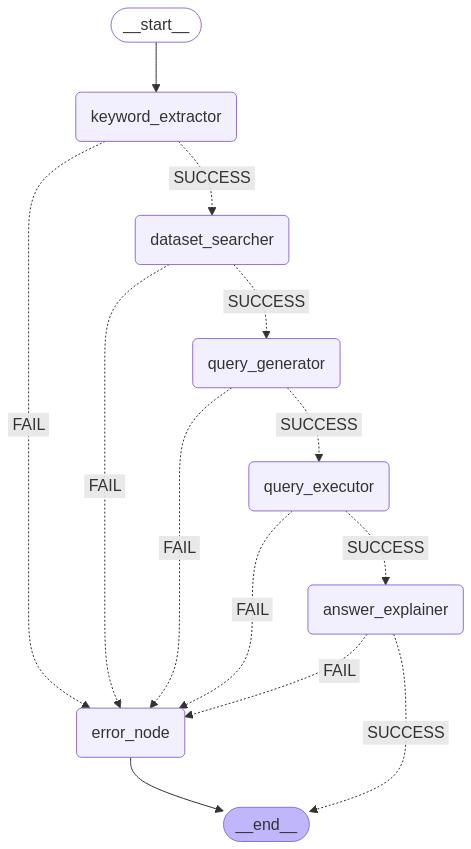

In [26]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"question":"電影票房與空氣品質的關係"})

In [25]:
for step in graph.stream(
    {"question":"電影票房與空氣品質的關係"}, stream_mode="updates"
):
    print(step)

{'keyword_extractor': {'keywords': ['電影票房', '空氣品質']}}
{'dataset_searcher': {'error': "Dataset Searcher failed: 2 validation errors for dataset_search_output\ndatasets.0.columns\n  Field required [type=missing, input_value={'id': 'dnT3tXLZuxggmFdXG...-air.araliadata.io/api'}, input_type=dict]\n    For further information visit https://errors.pydantic.dev/2.10/v/missing\ndatasets.1.columns\n  Field required [type=missing, input_value={'id': '6h7D2wyfsxx6BUadP...ment.araliadata.io/api'}, input_type=dict]\n    For further information visit https://errors.pydantic.dev/2.10/v/missing"}}
{'error_node': {'answer': '抱歉,資料搜尋時發生了錯誤,看起來我們提供的資料有遺漏必填的欄位。我們會盡快修正此問題。感謝您的耐心等候!'}}


In [ ]:
# 以Gradio作為GUI串接介面，讓使用者可以和RAG進行問答
def predict(message,history):
    return graph.invoke({"question":message})['answer']

gr.ChatInterface(predict).launch()